<a href="https://colab.research.google.com/github/c-eloy/MLFlatDirections/blob/camille/GradientDescentPotentials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import time

In [2]:
import numpy as np

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
def V3(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return (x4**2+(x2-x3+x4)**2+(x1+x2+x3+x4)**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1+x2+x3+x4-tf.sqrt(3.)*(x2+x3+x4)**2)**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1+x2+x3+x4+tf.sqrt(3.)*(x2+x3+x4)**2)**2)

# compute (||∇V||^2)
def grad_norm_squared(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

def get_grad(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    return gradients


In [6]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1}")
    for i in range(ndim):
        for j in range(i):
            plt.subplot(ndim,ndim,ndim*i+j+1)
            counts,xbins,ybins,image = plt.hist2d(data[:,j],data[:,i],bins=100
                                      ,norm=LogNorm()
                                      ,cmap = plt.cm.rainbow)
            plt.colorbar()
            plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
    plt.show()

def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
            #ax.set_ylabel(f"x{i}")
    plt.show()

In [7]:
def is_on_axis(x,axis,slope,err):
    these_slopes = x[:,axis[1]]/x[:,axis[0]]
    return np.abs(these_slopes-slope)<err

def is_on_x_squared(x,axis,coef,err):
    a,b,c=coef
    return np.abs(x[:,axis[0]]-(a*x[:,axis[1]]**2+b*x[:,axis[1]]+c))<err

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# randomly initialize the points
n_points = 100000
x3 = tf.Variable(4*np.random.rand(n_points, 4)-2, dtype=tf.float32)

In [ ]:
# Oprimizer for the gradient descent
start = time.time()
init_alpha=10**(-2)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)
#optimizer = tf.optimizers.Ftrl(learning_rate=10**(-3))

# Learning loop
loss_prev_step=10**8

update_alpha = False
update_opt = True
for step in range(3300):
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V3, x3)) # minimize ||∇V||^2 for all points

    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x3])

    if update_alpha and step % 300 == 0 and step != 0:
        #if step < 2700:
        #  optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
        #else:
        alpha = alpha/2
        optimizer.learning_rate.assign(alpha)
    if update_opt and step % 300 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if loss.numpy()<10 and update_opt:
        update_alpha = True
        update_opt = False
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
        print("Turning update_alpha to True and update_opt to False")

    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x3]))

    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")

    if np.log(loss.numpy())/np.log(10)<-6:
        print("Converged enough")
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

end = time.time()
print(f"Total time for {n_points} is {end-start}")

Reinitializing the optimizer
Step 0: ||∇V||^2 = 1.5417046930198364e+18 with learning rate 0.009999999776482582


KeyboardInterrupt: 

In [ ]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V3,x3)**2,axis=1).numpy()>10**(-i))}")


In [ ]:
triangular_plot(x3.numpy())

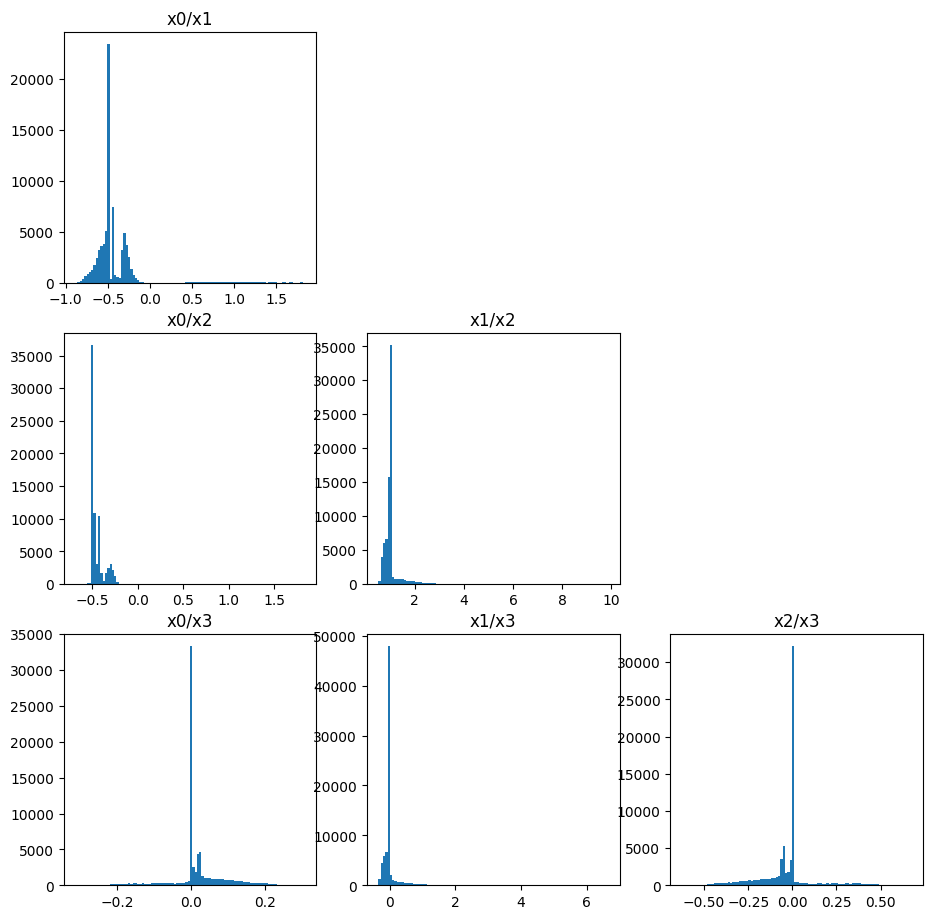

In [ ]:
triangular_plot_slopes(x3)

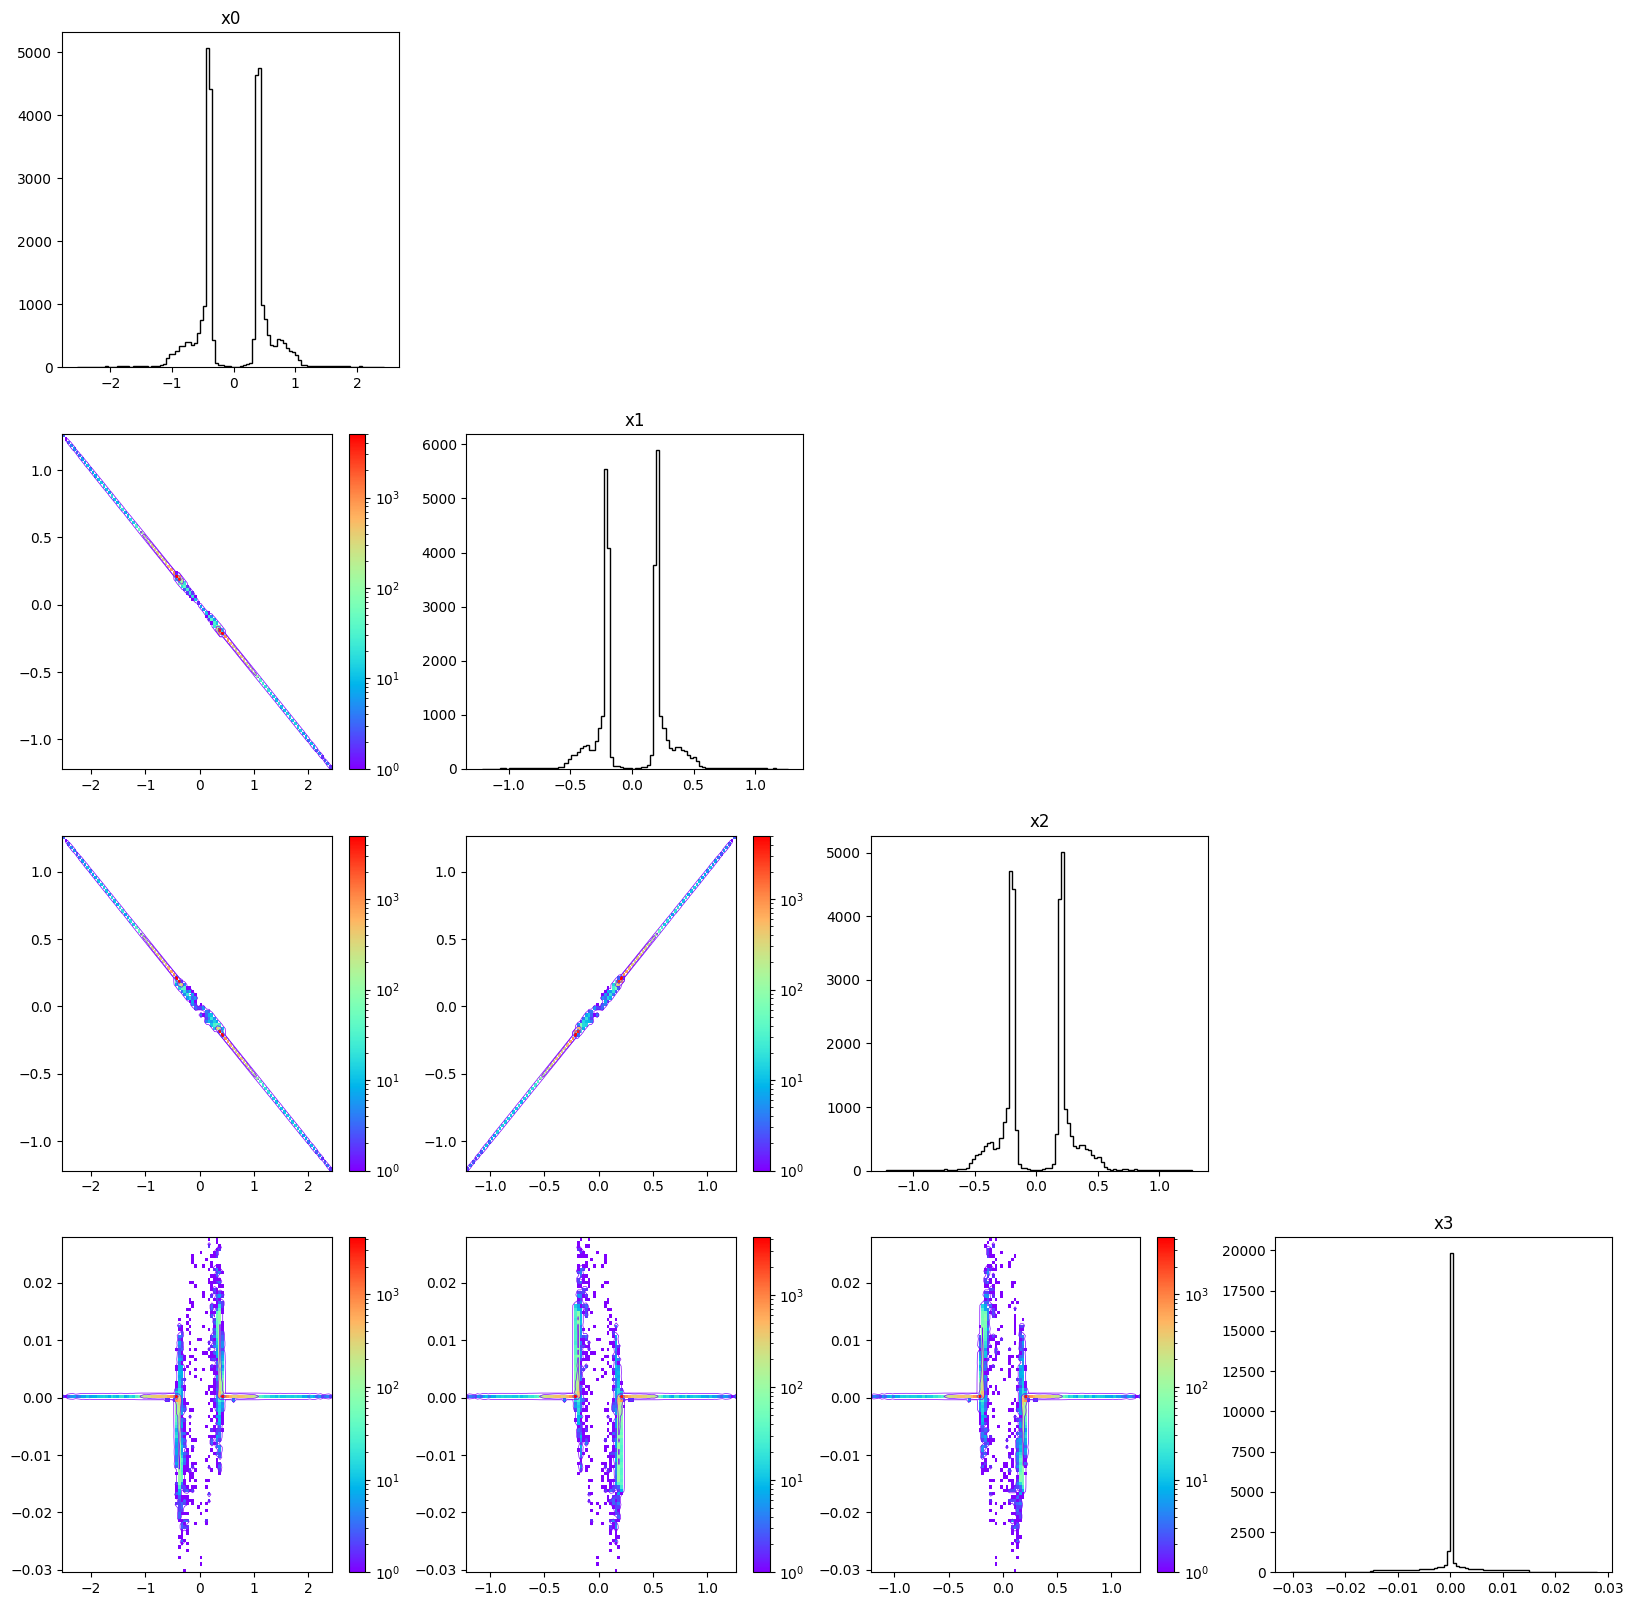

In [ ]:
mask_points_m5=is_on_axis(x3.numpy(),(0,1),-0.5,0.05)
points_m5=np.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)

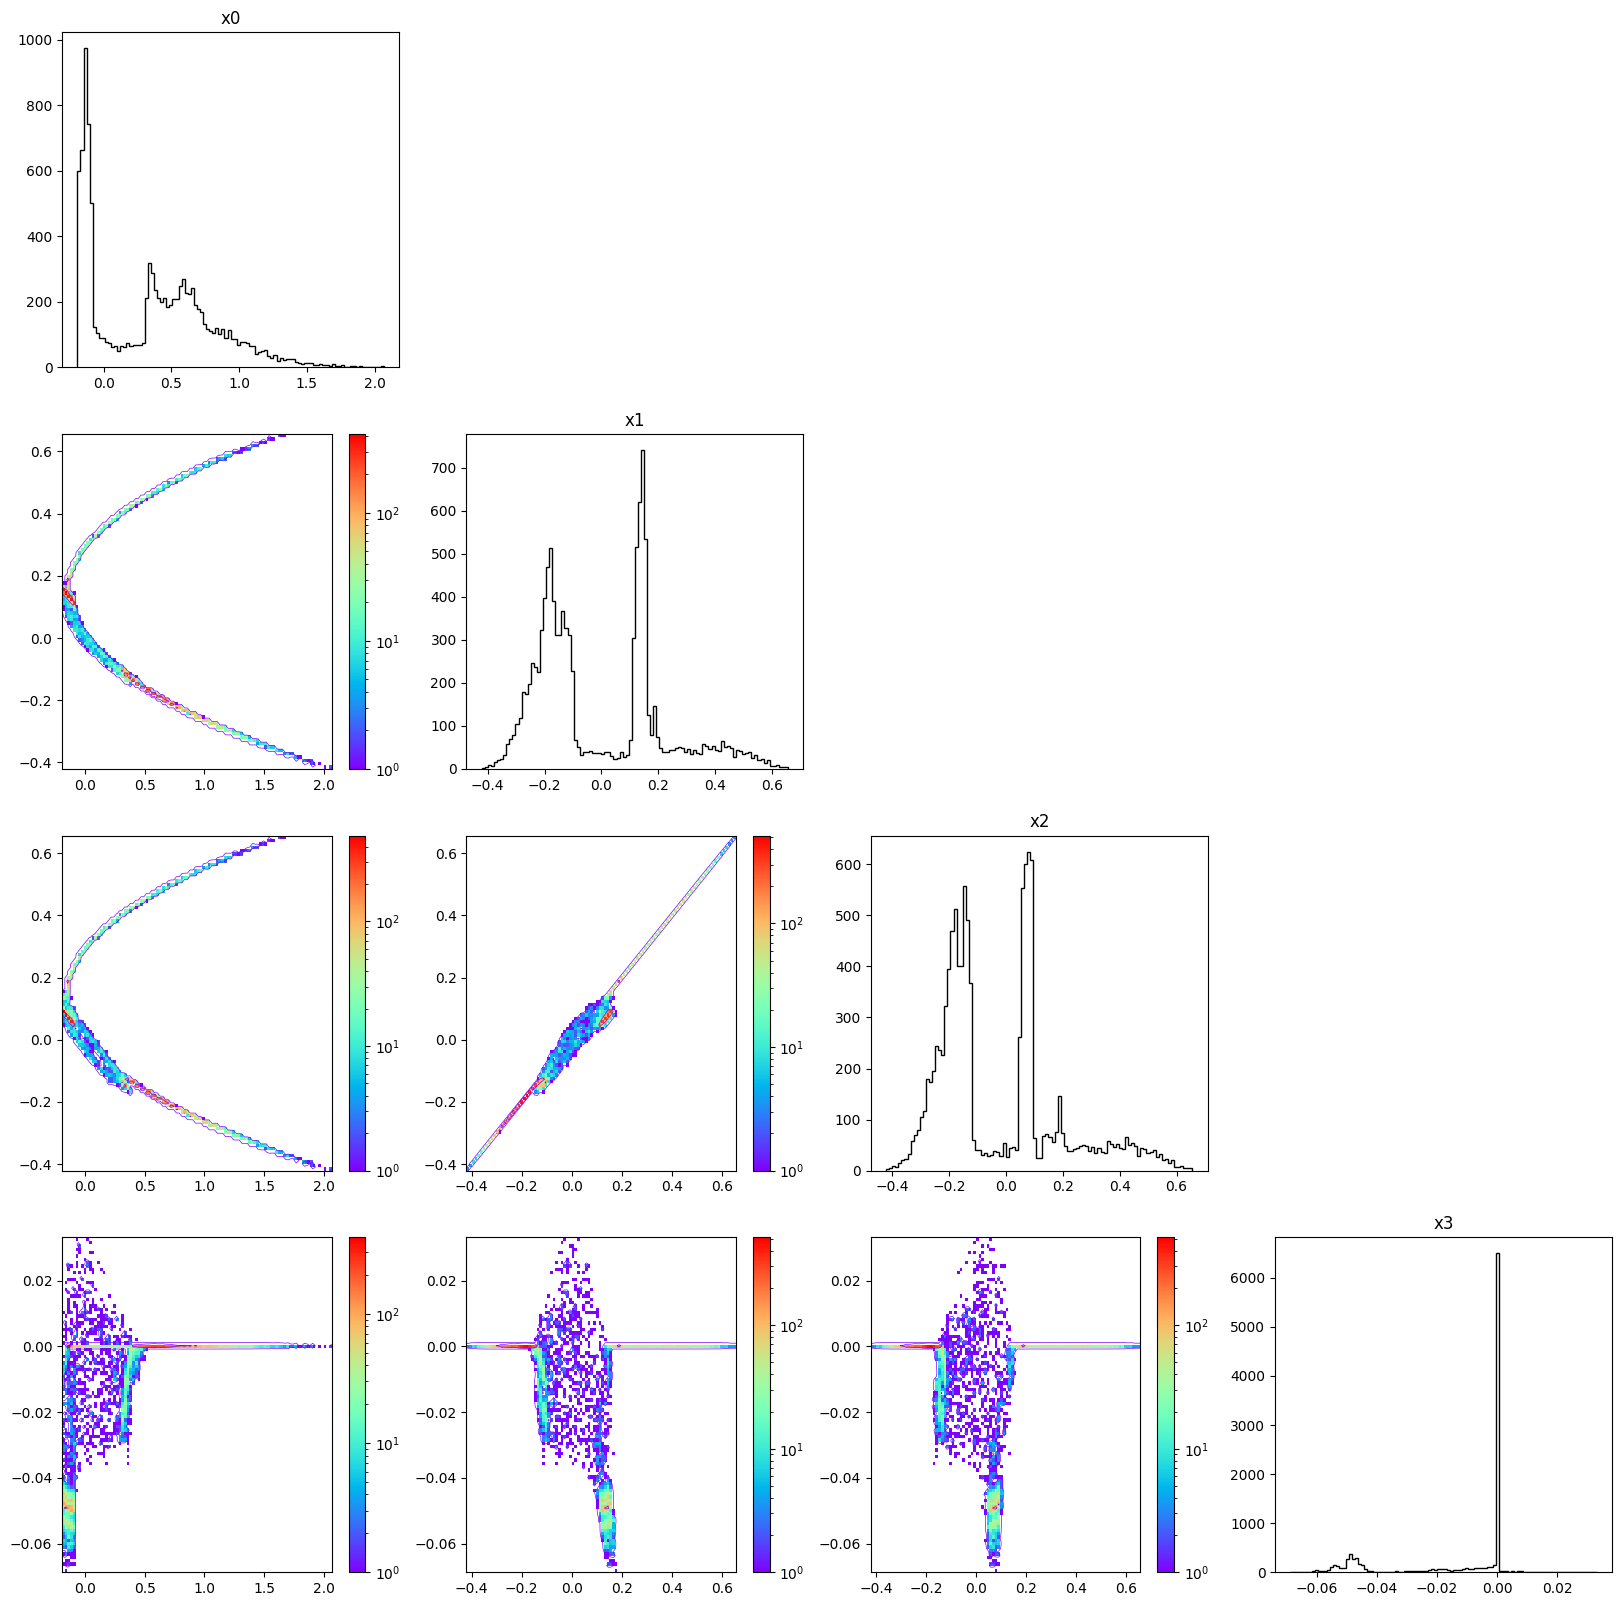

In [ ]:
mask_points_m5=is_on_x_squared(x3.numpy(),(0,1),(4*tf.sqrt(3.),-2,0),0.05)
points_m5=tf.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)

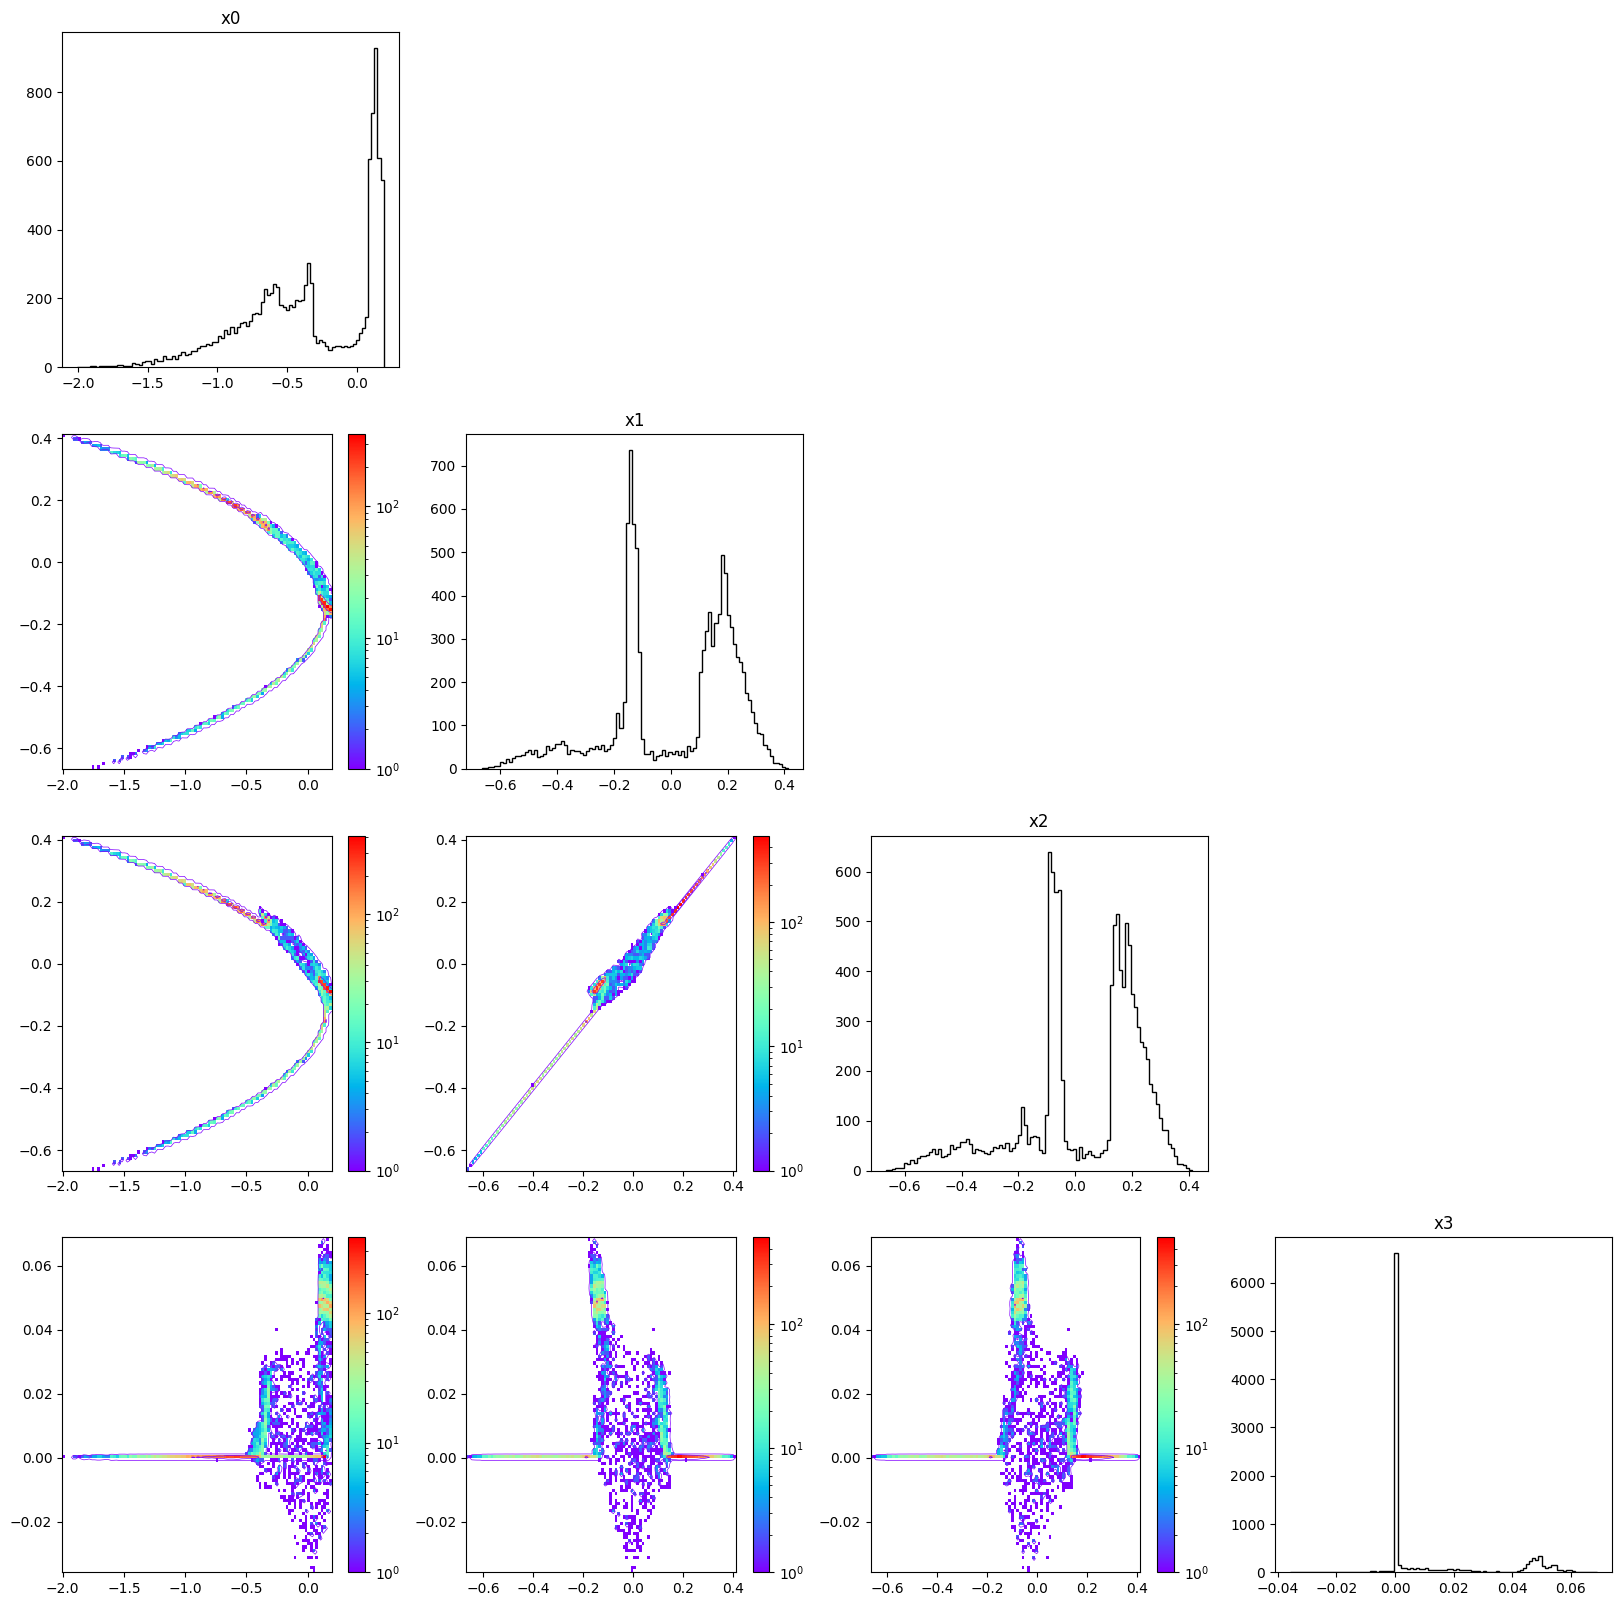

In [ ]:
mask_points_m5=is_on_x_squared(x3.numpy(),(0,1),(-4*tf.sqrt(3.),-2,0),0.05)
points_m5=np.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)

In [ ]:
# Same with 13 d potential

In [8]:
def V13(x):
  x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12=tf.split(x, 12, axis=1)
  x13 = 0
  return 0.001953125 * (tf.exp(2 * x13 -6 * x7 -2 * x8 -4 * (3 ** -0.5) * x9)) * (1024 * (tf.exp(2 * x13 + 6 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) + 256 * (tf.exp(12 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) + 512 * (tf.exp(10 * x7 + x8 + (tf.sqrt(3.)) * x9)) * (x1 ** 2) + 256 * (tf.exp(8 * x7 + 2 * (3 ** -0.5) * x9)) * (x1 ** 4) -512 * (tf.sqrt(2.)) * (tf.exp(10 * x7 + 2 * x8 + (tf.sqrt(3.)) * x9)) * x1 * x10 * x2 -512 * (tf.sqrt(2.)) * (tf.exp(8 * x7 + x8 + 2 * (3 ** -0.5) * x9)) * (x1 ** 3) * x10 * x2 + 256 * (tf.exp(10 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9)) * (2 + x10 ** 2) * (x2 ** 2) -256 * (tf.sqrt(2.)) * (tf.exp(8 * x7 + 3 * x8 + 2 * (3 ** -0.5) * x9)) * x1 * x10 * (2 + x10 ** 2) * (x2 ** 3) + 64 * (tf.exp(8 * x7 + 4 * x8 + 2 * (3 ** -0.5) * x9)) * ((2 + x10 ** 2) ** 2) * (x2 ** 4) -256 * (tf.exp(10 * x7 + 1.5 * (x8 + (tf.sqrt(3.)) * x9))) * x1 * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * x3 -256 * (tf.exp(8 * x7 + 0.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (x1 ** 3) * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * x3 -128 * (tf.exp(10 * x7 + 2.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9)) * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * x2 * x3 -64 * (tf.exp(8 * x7 + 1.166666666666667 * (3 * x8 + (tf.sqrt(3.)) * x9))) * (2 + x10 ** 2) * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * (x2 ** 3) * x3 + 32 * (tf.exp(2 * (5 * x7 + x8 + (tf.sqrt(3.)) * x9))) * (16 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) -16 * (tf.exp(8 * x7 + 1.5 * x8 + 6.5 * (3 ** -0.5) * x9)) * x1 * (16 * (tf.sqrt(2.)) * (x11 ** 3) -24 * x10 * (x11 ** 2) * x12 -(x10 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2))) + 2 * (tf.sqrt(2.)) * x11 * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2))) * (x3 ** 3) -8 * (tf.exp(8 * x7 + 2.5 * x8 + 6.5 * (3 ** -0.5) * x9)) * (-12 * (x10 ** 3) * x11 * (x12 ** 2) + (tf.sqrt(2.)) * (x10 ** 4) * (x12 ** 3) + 32 * (tf.sqrt(2.)) * x12 * (2 + x11 ** 2 + x12 ** 2) -32 * x10 * x11 * (2 + x11 ** 2 + 2 * (x12 ** 2)) + 4 * (tf.sqrt(2.)) * (x10 ** 2) * x12 * (4 + 6 * (x11 ** 2) + 3 * (x12 ** 2))) * x2 * (x3 ** 3) + (tf.exp(8 * x7 + 2 * x8 + 8 * (3 ** -0.5) * x9)) * (64 * (x11 ** 4) -64 * (tf.sqrt(2.)) * x10 * (x11 ** 3) * x12 -8 * (tf.sqrt(2.)) * x10 * x11 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2)) + (16 + (8 + x10 ** 2) * (x12 ** 2)) ** 2 + 16 * (x11 ** 2) * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2))) * (x3 ** 4) + 2048 * (tf.exp(6 * x7 + x8 + (3 ** -0.5) * x9)) * (x1 ** 2) * (x4 ** 2) -2048 * (tf.sqrt(2.)) * (tf.exp(6 * x7 + 2 * x8 + (3 ** -0.5) * x9)) * x1 * x10 * x2 * (x4 ** 2) + 1024 * (tf.exp(6 * x7 + 3 * x8 + (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (x2 ** 2) * (x4 ** 2) + 256 * (tf.exp(4 * x7 + 2 * x8)) * ((1 + 4 * (x4 ** 2)) ** 2) + 256 * (tf.exp(8 * x7 + 2 * x8 + 2 * (3 ** -0.5) * x9)) * (-2 + (x1 ** 2) * (2 + 3 * (x10 ** 2)) * (x2 ** 2) + 8 * (x4 ** 2)) -2048 * (tf.sqrt(2.)) * (tf.exp(6 * x7 + 0.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * (x1 ** 2) * x12 * x4 * x5 -2048 * (tf.sqrt(2.)) * (tf.exp(0.5 * (8 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9))) * x12 * x4 * (1 + 4 * (x4 ** 2)) * x5 + 1024 * (tf.exp(6 * x7 + 4 * (3 ** -0.5) * x9)) * (x1 ** 2) * (2 + x12 ** 2) * (x5 ** 2) -512 * (tf.exp(6 * x7 + 0.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x1 * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * (2 + x12 ** 2) * x3 * (x5 ** 2) + 64 * (tf.exp(6 * x7 + x8 + 7 * (3 ** -0.5) * x9)) * (2 + x12 ** 2) * (16 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) * (x5 ** 2) -128 * (tf.exp(8 * x7 + 1.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * ((x1 ** 2) * (-12 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + 3 * (tf.sqrt(2.)) * (x10 ** 2) * x12) * x2 * x3 + 16 * (tf.sqrt(2.)) * x12 * x4 * x5) -1024 * (tf.sqrt(2.)) * (tf.exp(0.5 * (8 * x7 + x8 + 3 * (tf.sqrt(3.)) * x9))) * x12 * (2 + x12 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) + 64 * (tf.exp(4 * x7 + 2 * (tf.sqrt(3.)) * x9)) * ((2 + x12 ** 2) ** 2) * ((1 + 4 * (x5 ** 2)) ** 2) + 32 * (tf.exp(8 * x7 + x8 + 5 * (3 ** -0.5) * x9)) * (-12 * (tf.sqrt(2.)) * (x1 ** 2) * x10 * x11 * x12 * (x3 ** 2) + 8 * (-2 + (x1 ** 2) * (2 + 3 * (x11 ** 2)) * (x3 ** 2) + 8 * (x5 ** 2)) + (x12 ** 2) * (-8 + (x1 ** 2) * (8 + 3 * (x10 ** 2)) * (x3 ** 2) + 32 * (x5 ** 2))) + 512 * (tf.exp(6 * x7 + 3.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * (x2 ** 2) * x4 * x6 + 1024 * (tf.exp(0.5 * (8 * x7 + 5 * x8 + (tf.sqrt(3.)) * x9))) * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * x4 * (1 + 4 * (x4 ** 2)) * x6 -32 * (tf.exp(6 * x7 + 2 * x8 + 7 * (3 ** -0.5) * x9)) * ((tf.sqrt(2.)) * (x10 ** 3) * (x12 ** 2) * (4 + x12 ** 2) -4 * (x10 ** 2) * x11 * x12 * (8 + x12 ** 2) + 32 * x11 * x12 * (2 + x11 ** 2 + x12 ** 2) + 8 * (tf.sqrt(2.)) * x10 * (8 + 6 * (x12 ** 2) + x12 ** 4 -((x11 ** 2) * (-4 + x12 ** 2)))) * (x3 ** 2) * x5 * x6 -256 * (tf.exp(4 * x7 + x8 + 2 * (tf.sqrt(3.)) * x9)) * (2 + x12 ** 2) * (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2)) * x5 * (1 + 4 * (x5 ** 2)) * x6 + 64 * (tf.exp(6 * x7 + 4 * x8 + 4 * (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (8 * (2 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x2 ** 2) * (x6 ** 2) -32 * (tf.exp(6 * x7 + 3.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * (32 * (tf.sqrt(2.)) * (2 + x11 ** 2) * x12 -32 * x10 * x11 * (2 + x11 ** 2 -(x12 ** 2)) + 4 * (x10 ** 3) * x11 * (-8 + x12 ** 2) + (tf.sqrt(2.)) * (x10 ** 4) * x12 * (8 + x12 ** 2) + 4 * (tf.sqrt(2.)) * (x10 ** 2) * x12 * (12 -2 * (x11 ** 2) + x12 ** 2)) * x2 * x3 * (x6 ** 2) + 8 * (tf.exp(6 * x7 + 3 * x8 + 7 * (3 ** -0.5) * x9)) * (-32 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 + 32 * (tf.sqrt(2.)) * x10 * x11 * (x12 ** 3) + (x10 ** 4) * (x12 ** 2) * (8 + x12 ** 2) + 64 * (2 + x11 ** 2) * (2 + x11 ** 2 + x12 ** 2) + 8 * (x10 ** 2) * (16 + 12 * (x12 ** 2) + x12 ** 4 -2 * (x11 ** 2) * (-4 + x12 ** 2))) * (x3 ** 2) * (x6 ** 2) + 512 * (tf.exp(2 * x7 + 2 * x8 + 2 * (3 ** -0.5) * x9)) * ((x3 + 4 * x3 * (x4 ** 2) -4 * x2 * x4 * x5 + 4 * x1 * x4 * x6) ** 2) -128 * (tf.exp(8 * x7 + 2.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (x1 * (2 * (tf.sqrt(2.)) * (2 + 3 * (x10 ** 2)) * x11 -(x10 * (10 + 3 * (x10 ** 2)) * x12)) * (x2 ** 2) * x3 -8 * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * x4 * x6) -32 * (tf.exp(8 * x7 + 2 * x8 + 5 * (3 ** -0.5) * x9)) * (x1 * (-32 * x11 * x12 -24 * (x10 ** 2) * x11 * x12 + 3 * (tf.sqrt(2.)) * (x10 ** 3) * (x12 ** 2) + 8 * (tf.sqrt(2.)) * x10 * (2 + 3 * (x11 ** 2) + 2 * (x12 ** 2))) * x2 * (x3 ** 2) + 16 * (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2)) * x5 * x6) + 64 * (tf.exp(4 * x7 + 3.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9)) * (16 * (tf.sqrt(2.)) * (x11 ** 3) + 24 * x10 * (x11 ** 2) * x12 + x10 * x12 * (16 + (x10 ** 2) * (8 + x12 ** 2)) + 2 * (tf.sqrt(2.)) * x11 * (16 + (x10 ** 2) * (8 + 3 * (x12 ** 2)))) * x4 * x6 * (1 + 4 * (x6 ** 2)) -32 * (tf.exp(4 * x7 + 3 * x8 + 2 * (tf.sqrt(3.)) * x9)) * (32 * x11 * (2 + x11 ** 2) * x12 + 4 * (x10 ** 2) * x11 * x12 * (16 + 3 * (x12 ** 2)) + (tf.sqrt(2.)) * (x10 ** 3) * (32 + 12 * (x12 ** 2) + x12 ** 4) + 8 * (tf.sqrt(2.)) * x10 * (2 * (4 + x12 ** 2) + (x11 ** 2) * (4 + 3 * (x12 ** 2)))) * x5 * x6 * (1 + 4 * (x6 ** 2)) + (tf.exp(4 * x7 + 4 * x8 + 2 * (tf.sqrt(3.)) * x9)) * (64 * ((2 + x11 ** 2) ** 2) + 64 * (tf.sqrt(2.)) * x10 * x11 * (2 + x11 ** 2) * x12 + 8 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 * (8 + x12 ** 2) + (x10 ** 4) * ((8 + x12 ** 2) ** 2) + 16 * (x10 ** 2) * (2 * (8 + x12 ** 2) + (x11 ** 2) * (8 + 3 * (x12 ** 2)))) * ((1 + 4 * (x6 ** 2)) ** 2) + 32 * (tf.exp(2 * x7 + 3 * x8 + 5 * (3 ** -0.5) * x9)) * (8 * (2 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * ((x1 + 4 * x3 * x4 * x6 -4 * x2 * x5 * x6 + 4 * x1 * (x6 ** 2)) ** 2) + 256 * (tf.exp(2 * x7 + x8 + 5 * (3 ** -0.5) * x9)) * (2 + x12 ** 2) * ((x2 + 4 * x2 * (x5 ** 2) -4 * x5 * (x3 * x4 + x1 * x6)) ** 2) + 1024 * (tf.exp(6 * x7 + 1.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * x1 * x4 * (2 * (tf.sqrt(2.)) * x11 * (-(x3 * x4) + x1 * x6) + x10 * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6)) -512 * (tf.exp(6 * x7 + 0.8333333333333333 * (3 * x8 + (tf.sqrt(3.)) * x9))) * x2 * x4 * (4 * (tf.sqrt(2.)) * x12 * (x3 * x4 + x2 * x5) + (tf.sqrt(2.)) * (x10 ** 2) * x12 * (x3 * x4 + 2 * x2 * x5 + 2 * x1 * x6) + x10 * x11 * (-4 * x3 * x4 + 8 * x1 * x6)) -128 * (tf.exp(6 * x7 + 1.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x3 * x5 * (-8 * x10 * x11 * (x12 ** 2) * (x3 * x4 + x2 * x5) -16 * x10 * x11 * (x2 * x5 + 2 * x1 * x6) + (tf.sqrt(2.)) * (x12 ** 3) * ((8 + x10 ** 2) * x3 * x4 + 2 * (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2) * x6) + 4 * (tf.sqrt(2.)) * x12 * (2 * (2 + x11 ** 2) * x3 * x4 + (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2 -2 * (x11 ** 2)) * x6)) -512 * (tf.exp(4 * x7 + 2 * x8 + (tf.sqrt(3.)) * x9)) * (4 * x11 * x12 * (1 + 12 * (x4 ** 2)) * x5 * x6 + (tf.sqrt(2.)) * x1 * x10 * (x2 * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 2) * x3 * x4 * x5 + (x2 ** 3) * (-1 + 4 * (x5 ** 2)) + 2 * x3 * x6) -2 * (tf.sqrt(2.)) * (x1 ** 2) * x10 * (x4 -4 * x2 * x3 * x4 * x6 + 4 * (x2 ** 2) * x5 * x6) + (tf.sqrt(2.)) * x10 * (2 * (x2 ** 2) * x4 + 2 * x2 * x3 * x5 + (-4 + x12 ** 2 + 16 * (x4 ** 2) + 12 * (x12 ** 2) * (x4 ** 2)) * x5 * x6) + (tf.sqrt(2.)) * (x1 ** 3) * x10 * x2 * (-1 + 4 * (x6 ** 2))) + 256 * (tf.exp(2 * x8 + 4 * (3 ** -0.5) * x9)) * (((x3 ** 2) * (1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 2) * (1 + 4 * (x6 ** 2))) ** 2) + 256 * (tf.exp(4 * x7 + x8 + (tf.sqrt(3.)) * x9)) * (-2 -8 * (x4 ** 2) -8 * (x5 ** 2) + 32 * (x4 ** 2) * (x5 ** 2) + 8 * x1 * (x2 * x4 + x3 * x5) + 2 * (x1 ** 2) * ((x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (-1 + 4 * (x5 ** 2))) + (x12 ** 2) * (1 + 4 * (x5 ** 2) + (x4 ** 2) * (4 + 48 * (x5 ** 2))) + 16 * (x1 ** 3) * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 4) * (-2 + 8 * (x6 ** 2))) + 128 * (tf.exp(6 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) * ((x3 ** 2) * (-8 + (32 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x4 ** 2)) -8 * (4 + 2 * (tf.sqrt(2.)) * x10 * x11 * x12 -4 * (x12 ** 2) -((x10 ** 2) * (x12 ** 2))) * x2 * x3 * x4 * x5 + 4 * (x2 ** 2) * (-2 + ((x10 ** 2) * (2 + x12 ** 2) + 2 * (4 + x12 ** 2)) * (x5 ** 2)) -4 * x1 * ((-8 + 8 * (x11 ** 2) -((x10 ** 2) * (x12 ** 2))) * x3 * x4 -2 * (-4 + 2 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (4 + x12 ** 2)) * x2 * x5) * x6 + (x1 ** 2) * (-8 + (8 * (4 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x6 ** 2))) -512 * (tf.sqrt(2.)) * (tf.exp(2 * x7 + 1.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * x12 * (4 * (x2 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) -(x2 * (x3 + 4 * x3 * (x5 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x5 ** 2)) + 4 * x1 * x4 * (1 + 8 * (x5 ** 2)) * x6)) + 4 * x5 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) + x1 * x3 * (1 + 8 * (x4 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * (x6 ** 2))) -256 * (tf.exp(4 * x7 + 1.5 * (x8 + (tf.sqrt(3.)) * x9))) * (-2 * (x1 ** 2) * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * (x5 -4 * (x3 ** 2) * x4 * x6 + 4 * x2 * x3 * x5 * x6) + 4 * (tf.sqrt(2.)) * x11 * (x2 * x3 * x4 + (x3 ** 2) * x5 -(x4 * (-2 + x12 ** 2 + 8 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6)) -2 * x10 * x12 * (x2 * x3 * x4 + (x3 ** 2) * x5 + x4 * (6 + x12 ** 2 + 40 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6) + (x1 ** 3) * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * x3 * (-1 + 4 * (x6 ** 2)) + x1 * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * ((x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 2) * x3 * (-1 + 4 * (x5 ** 2)) -2 * x2 * (4 * (x3 ** 2) * x4 * x5 + x6))) -512 * (tf.exp(6 * x7 + x8 + 4 * (3 ** -0.5) * x9)) * x1 * x5 * (x11 * x12 * (-8 * x3 * x4 + 4 * x1 * x6) + (tf.sqrt(2.)) * x10 * (4 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6))) -128 * (tf.exp(6 * x7 + 3 * x8 + 4 * (3 ** -0.5) * x9)) * x2 * x6 * (16 * x11 * x12 * (2 * x3 * x4 + x2 * x5) + 8 * (x10 ** 2) * x11 * x12 * (x2 * x5 + x1 * x6) + (tf.sqrt(2.)) * (x10 ** 3) * (8 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6)) + 4 * (tf.sqrt(2.)) * x10 * (2 * (x12 ** 2) * x3 * x4 + 4 * x2 * x5 + (x12 ** 2) * x2 * x5 + 4 * x1 * x6 + (x11 ** 2) * (-4 * x3 * x4 + 2 * x1 * x6))) + 64 * (tf.exp(6 * x7 + 2.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x3 * x6 * (16 * (tf.sqrt(2.)) * (x11 ** 3) * (x3 * x4 -(x1 * x6)) -8 * x10 * (x11 ** 2) * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6) + x10 * x12 * ((16 + (8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 4 * (4 + x10 ** 2) * (4 + x12 ** 2) * x2 * x5 + x1 * (16 + (x10 ** 2) * (8 + x12 ** 2)) * x6) -2 * (tf.sqrt(2.)) * x11 * ((-16 + (-8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 16 * (-((x12 ** 2) * x2 * x5) + x1 * x6) + (x10 ** 2) * (16 * x2 * x5 -(x1 * (-8 + x12 ** 2) * x6)))) + 16 * (tf.exp(8 * x7 + 3 * x8 + 5 * (3 ** -0.5) * x9)) * (-12 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 * (x2 ** 2) * (x3 ** 2) + 3 * (x10 ** 4) * (x12 ** 2) * (x2 ** 2) * (x3 ** 2) -8 * (tf.sqrt(2.)) * x10 * x11 * x12 * (1 + 5 * (x2 ** 2) * (x3 ** 2) -4 * (x6 ** 2)) + 16 * (-2 + (2 + 3 * (x12 ** 2)) * (x2 ** 2) * (x3 ** 2) + 8 * (x6 ** 2) + (x11 ** 2) * (-1 + (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2))) + 2 * (x10 ** 2) * (-8 + 4 * (2 + 3 * (x11 ** 2)) * (x2 ** 2) * (x3 ** 2) + 32 * (x6 ** 2) + (x12 ** 2) * (-1 + 13 * (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2)))) + 256 * (tf.exp(2 * x7 + 2.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * (4 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) -(x2 * x3 * (1 + 8 * (x4 ** 2)) * x5) + 4 * (x2 ** 2) * x4 * (x5 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * x6 * (1 + 4 * (x6 ** 2)) + x1 * (x3 + 4 * x3 * (x6 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x6 ** 2)) -4 * x2 * x4 * x5 * (1 + 8 * (x6 ** 2)))) -128 * (tf.exp(2 * x7 + 2 * x8 + 5 * (3 ** -0.5) * x9)) * (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2)) * (4 * (4 * (x3 ** 2) * (x4 ** 2) * x5 -(x2 * x3 * x4 * (1 + 8 * (x5 ** 2))) + (x2 ** 2) * (x5 + 4 * (x5 ** 3))) * x6 + 4 * (x1 ** 2) * x5 * x6 * (1 + 4 * (x6 ** 2)) -(x1 * (x2 + 4 * x2 * (x6 ** 2) -4 * x3 * x4 * x5 * (1 + 8 * (x6 ** 2)) + 4 * x2 * (x5 ** 2) * (1 + 8 * (x6 ** 2))))) -128 * (tf.exp(4 * x7 + 2.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9)) * ((x1 ** 2) * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * x2 * x3 * (-1 + 4 * (x6 ** 2)) -2 * x1 * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * (x2 * x5 -4 * x2 * (x3 ** 2) * x4 * x6 + x3 * (x4 + 4 * (x2 ** 2) * x5 * x6)) + (tf.sqrt(2.)) * (x10 ** 2) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x6 * (x3 ** 2 + 32 * x4 * x5 * x6) + (x12 ** 2) * x4 * x5 * (1 + 12 * (x6 ** 2))) + 4 * x10 * x11 * (x2 * (x3 ** 3) * (1 -4 * (x4 ** 2)) + (x2 ** 3) * (x3 -4 * x3 * (x5 ** 2)) -2 * (x3 ** 2) * x6 + 2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (4 + x12 ** 2 + 16 * (x6 ** 2) + 12 * (x12 ** 2) * (x6 ** 2))) + 4 * (tf.sqrt(2.)) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) + 2 * (x3 ** 2) * x6 -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (-2 + 8 * (x6 ** 2) + (x11 ** 2) * (1 + 12 * (x6 ** 2))))) + 32 * (tf.exp(4 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9)) * (4 * (tf.sqrt(2.)) * x10 * x11 * x12 * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))) + 8 * (2 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (8 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))))) + 16 * (tf.exp(2 * (2 * x7 + x8 + (tf.sqrt(3.)) * x9))) * (4 * (tf.sqrt(2.)) * x10 * x11 * x12 * (2 * (3 + x3 ** 4 -4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (1 -4 * (x5 ** 2)) + 12 * (x6 ** 2) + 80 * (x5 ** 2) * (x6 ** 2) + 4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) + 4 * x1 * x3 * (x5 -2 * (x3 ** 2) * x4 * x6 + 2 * x2 * x3 * x5 * x6) + (x1 ** 2) * (x3 ** 2) * (1 -4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (2 * (x12 ** 2) * (3 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 + 12 * (x6 ** 2) + 208 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + 16 * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2))) + (x12 ** 4) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + 8 * (2 * (2 + x12 ** 2) * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (2 * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))))))

In [13]:
# randomly initialize the points
n_points = 10000
x13 = tf.Variable(2*np.random.rand(n_points, 12)-1, dtype=tf.float32)
#x131 =tf.random.normal((n_points, 13),mean=0.0,stddev=1.0,)

In [14]:
# Optimizer for the gradient descent

init_alpha=10**(-3.)
alpha = init_alpha

#optimizer = tf.optimizers.SGD(learning_rate=alpha,momentum=0.9)

optimizer = tf.optimizers.Adam(learning_rate=alpha)

# Learning loop

#7,8,9,13

update_alpha = False
update_opt = True

for step in range(200,2000):
    start=time.time()
    with tf.GradientTape() as tape:
        tape.watch(x13)
        loss = tf.reduce_sum(grad_norm_squared(V13, x13)) * (1+np.tanh((2*step-1300)/100)) # minimize ||∇V||^2 for all points
        #penalty = tf.exp(tf.reduce_sum(x13[:,7]+x13[:,8]+x13[:,9]+x13[:,13],axis=1))

    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x13])

    if update_alpha and step % 200 == 0 and step != 0:
    #    alpha = 0.01
        alpha = alpha/2
        optimizer = tf.optimizers.Adam(learning_rate=alpha)
    #    update_alpha = False
    if update_opt and step % 50  == 0 and step != 0:
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
        print("Reinitialize optimizer")

    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x13]))

    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with lr = {optimizer.get_config()["learning_rate"]} and factor in loss = {(1+np.tanh((2*step-1300)/100))}""")

    if np.log(loss.numpy())/np.log(10)<-6:
        print("Converged enough")
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break
    end=time.time()
    #print(end-start)


Reinitialize optimizer
Step 200: ||∇V||^2 = 25754.857421875 with lr = 0.0010000000474974513 and factor in loss = 3.045995911055144e-08
2.928574562072754
2.5955963134765625
2.4987189769744873


KeyboardInterrupt: 

In [ ]:
 grad_those_points = tf.reduce_sum(get_grad(V13,x13)**2,axis=1).numpy()
 for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_those_points>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 75
Number of points with ||∇V||^2 > 0.1 : 147
Number of points with ||∇V||^2 > 0.01 : 6562
Number of points with ||∇V||^2 > 0.001 : 7096
Number of points with ||∇V||^2 > 0.0001 : 7380
Number of points with ||∇V||^2 > 1e-05 : 7629
Number of points with ||∇V||^2 > 1e-06 : 7818
Number of points with ||∇V||^2 > 1e-07 : 7929
Number of points with ||∇V||^2 > 1e-08 : 7975
Number of points with ||∇V||^2 > 1e-09 : 8007
Number of points with ||∇V||^2 > 1e-10 : 8040
Number of points with ||∇V||^2 > 1e-11 : 8059
Number of points with ||∇V||^2 > 1e-12 : 8078
Number of points with ||∇V||^2 > 1e-13 : 8096
Number of points with ||∇V||^2 > 1e-14 : 8114


In [ ]:
x13non_nan=np.extract(tf.math.is_nan(x13[:,0]),x13)
x13non_nan

array([-0.20509721, -0.23828004, -0.04555814, ...,  1.0068723 ,
        0.14331605, -5.7249856 ], dtype=float32)

In [ ]:
tile(tf.math.is_nan(x13[:,0]),13)

NameError: name 'tile' is not defined

ValueError: autodetected range of [nan, nan] is not finite

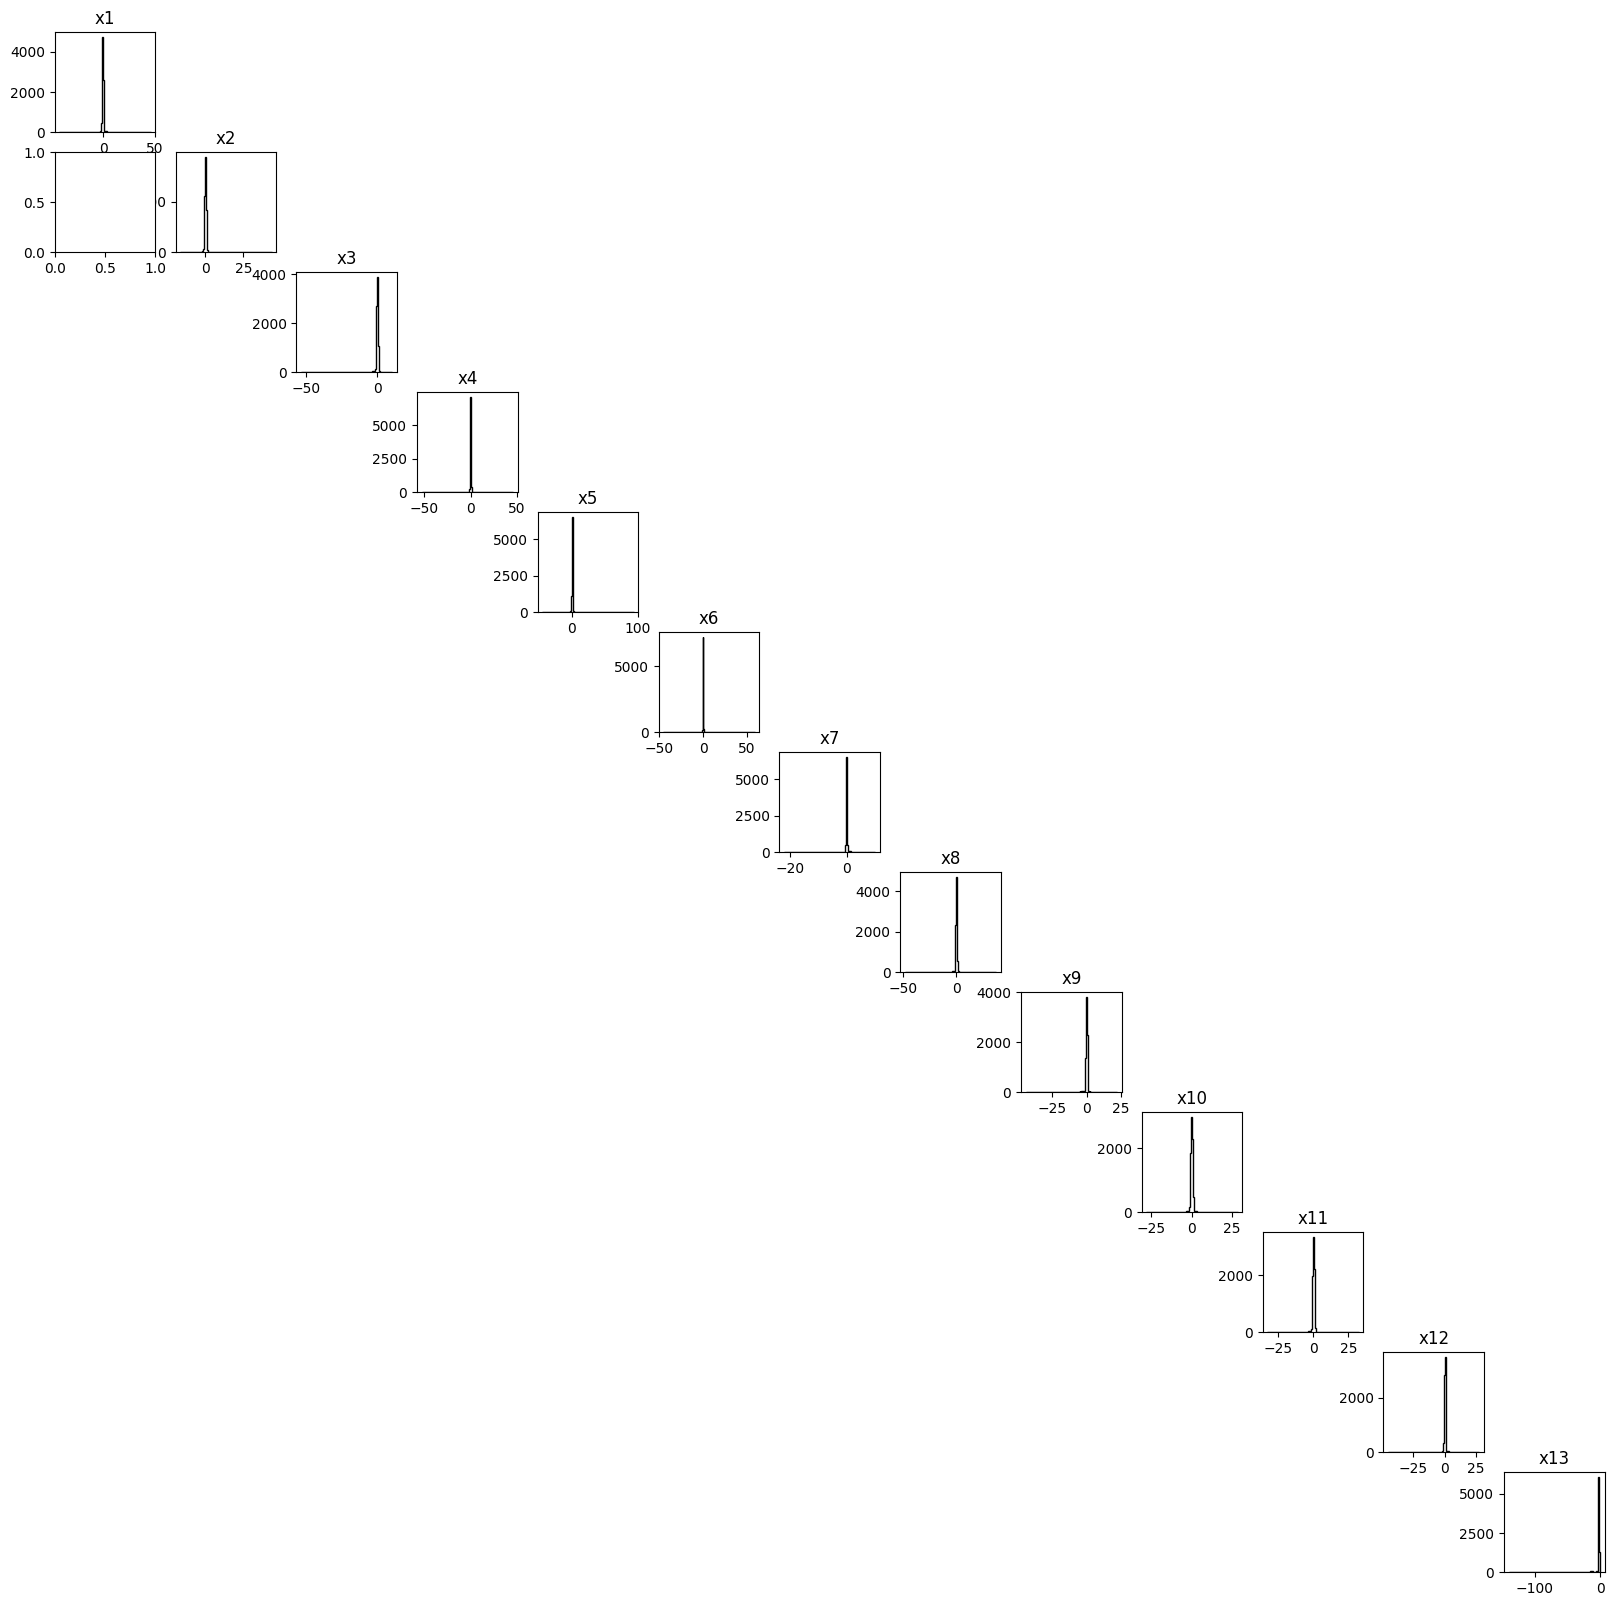

In [ ]:
triangular_plot(x13.numpy())

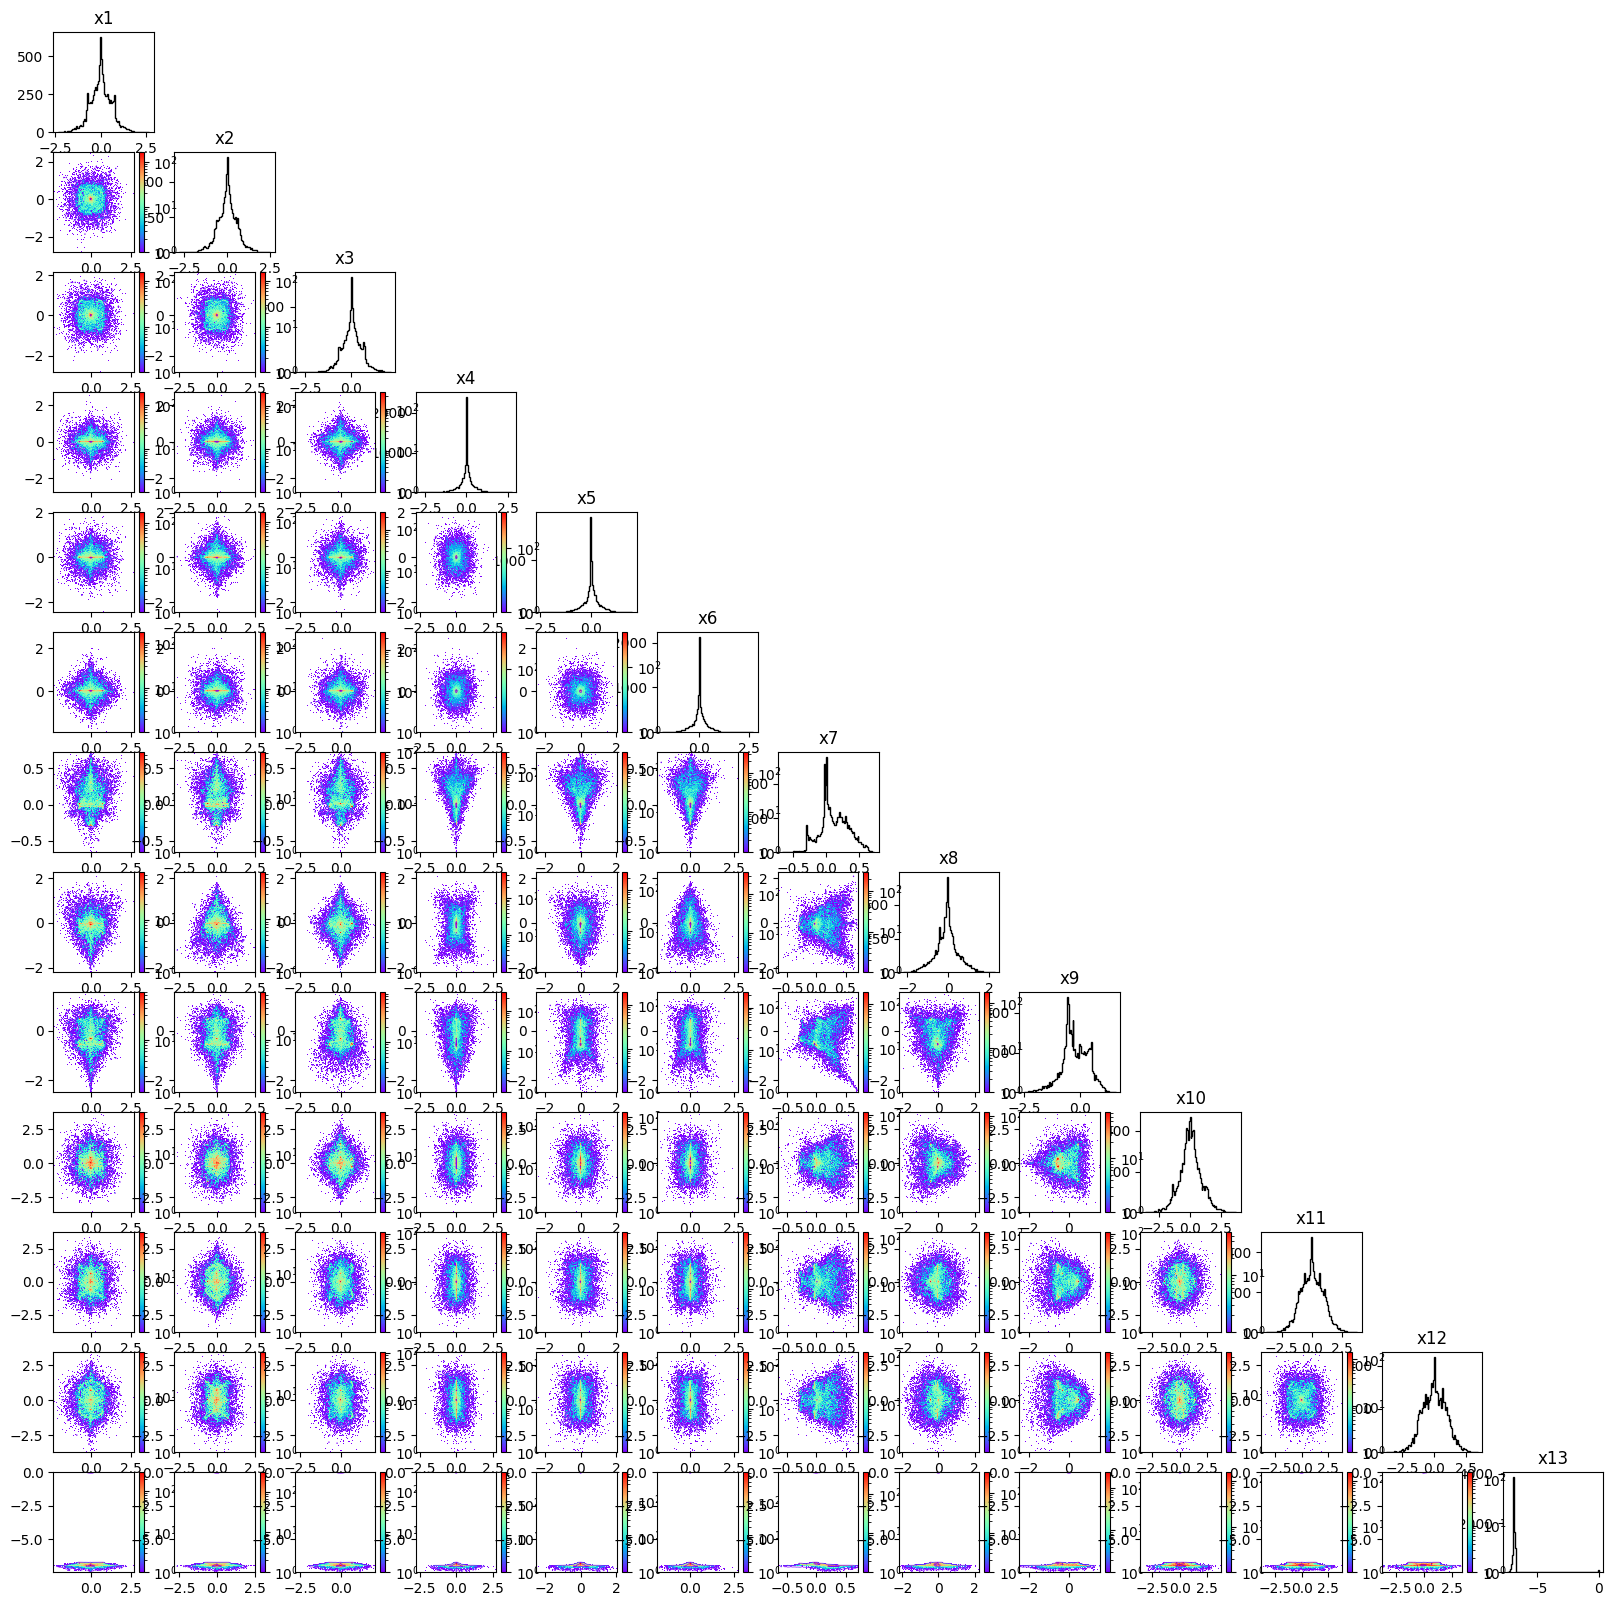

In [ ]:
#x13save=x13
triangular_plot(x13save)

In [ ]:
 grad_those_points = tf.reduce_sum(get_grad(V13,x13save)**2,axis=1).numpy()
 for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_those_points>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 5
Number of points with ||∇V||^2 > 1e-06 : 28
Number of points with ||∇V||^2 > 1e-07 : 51
Number of points with ||∇V||^2 > 1e-08 : 64
Number of points with ||∇V||^2 > 1e-09 : 71
Number of points with ||∇V||^2 > 1e-10 : 74
Number of points with ||∇V||^2 > 1e-11 : 10000
Number of points with ||∇V||^2 > 1e-12 : 10000
Number of points with ||∇V||^2 > 1e-13 : 10000
Number of points with ||∇V||^2 > 1e-14 : 10000


In [ ]:
def V13_1(x):
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13=tf.split(x,13,axis=1)
    term1 = (tf.exp(2 * x13 -6 * x7 -2 * x8 -4 * (3 ** -0.5) * x9))
    term2 = (tf.exp(2 * x13 + 6 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9))
    term3 = (tf.exp(12 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9))
    term4 = (tf.exp(10 * x7 + x8 + (tf.sqrt(3.)) * x9))
    term5 = (tf.exp(8 * x7 + 2 * (3 ** -0.5) * x9))
    term6 = (tf.sqrt(2.)) * (tf.exp(10 * x7 + 2 * x8 + (tf.sqrt(3.)) * x9))
    term7 = (tf.exp(8 * x7 + x8 + 2 * (3 ** -0.5) * x9))
    term8 = (tf.exp(10 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9))
    term9 = (2 + x10 ** 2) * (x2 ** 2) -256 * (tf.sqrt(2.)) * (tf.exp(8 * x7 + 3 * x8 + 2 * (3 ** -0.5) * x9))
    term10 = (tf.exp(8 * x7 + 4 * x8 + 2 * (3 ** -0.5) * x9))
    term11 = (tf.exp(10 * x7 + 1.5 * (x8 + (tf.sqrt(3.)) * x9)))
    term12 = (2 * (tf.sqrt(2.)) * x11 -(x10 * x12))
    term13 = (tf.exp(8 * x7 + 0.5 * x8 + 3.5 * (3 ** -0.5) * x9))
    term14 = (2 * (tf.sqrt(2.)) * x11 -(x10 * x12))
    term15 = (tf.exp(10 * x7 + 2.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9))
    term16 = (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12)
    term17 = (tf.exp(8 * x7 + 1.166666666666667 * (3 * x8 + (tf.sqrt(3.)) * x9)))
    term18 = (2 + x10 ** 2) * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * (x2 ** 3)
    term19 = (tf.exp(2 * (5 * x7 + x8 + (tf.sqrt(3.)) * x9))) * (16 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2))
    term20 = (tf.exp(8 * x7 + 1.5 * x8 + 6.5 * (3 ** -0.5) * x9))
    term21 = (16 * (tf.sqrt(2.)) * (x11 ** 3) -24 * x10 * (x11 ** 2) * x12 -(x10 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2))) + 2 * (tf.sqrt(2.)) * x11 * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2)))
    term22 = (tf.exp(8 * x7 + 2.5 * x8 + 6.5 * (3 ** -0.5) * x9))
    term23 = (-12 * (x10 ** 3) * x11 * (x12 ** 2) + (tf.sqrt(2.)) * (x10 ** 4) * (x12 ** 3) + 32 * (tf.sqrt(2.)) * x12 * (2 + x11 ** 2 + x12 ** 2) -32 * x10 * x11 * (2 + x11 ** 2 + 2 * (x12 ** 2)) + 4 * (tf.sqrt(2.)) * (x10 ** 2) * x12 * (4 + 6 * (x11 ** 2) + 3 * (x12 ** 2)))
    term24 = (tf.exp(8 * x7 + 2 * x8 + 8 * (3 ** -0.5) * x9))
    term25 = (64 * (x11 ** 4) -64 * (tf.sqrt(2.)) * x10 * (x11 ** 3) * x12 -8 * (tf.sqrt(2.)) * x10 * x11 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2)) + (16 + (8 + x10 ** 2) * (x12 ** 2)) ** 2 + 16 * (x11 ** 2) * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2)))
    term26 = (tf.exp(6 * x7 + x8 + (3 ** -0.5) * x9))
    term27 = (tf.exp(6 * x7 + 2 * x8 + (3 ** -0.5) * x9))
    term28 = (tf.exp(6 * x7 + 3 * x8 + (3 ** -0.5) * x9))
    term29 = (tf.exp(4 * x7 + 2 * x8)) * ((1 + 4 * (x4 ** 2)) ** 2)
    term30 = (2 + x10 ** 2) * (x2 ** 2) * (x4 ** 2)
    term31 = (tf.exp(8 * x7 + 2 * x8 + 2 * (3 ** -0.5) * x9))
    term32 = (-2 + (x1 ** 2) * (2 + 3 * (x10 ** 2)) * (x2 ** 2) + 8 * (x4 ** 2))
    term33 = (tf.sqrt(2.)) * (tf.exp(6 * x7 + 0.5 * x8 + 2.5 * (3 ** -0.5) * x9))
    term34 = (tf.sqrt(2.)) * (tf.exp(0.5 * (8 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9)))
    term35 = (tf.exp(6 * x7 + 4 * (3 ** -0.5) * x9)) * (x1 ** 2) * (2 + x12 ** 2) * (x5 ** 2)
    term36 = (tf.exp(6 * x7 + 0.5 * x8 + 5.5 * (3 ** -0.5) * x9))
    term37 = (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * (2 + x12 ** 2) * x3 * (x5 ** 2)
    term38 = (tf.exp(6 * x7 + x8 + 7 * (3 ** -0.5) * x9)) * (2 + x12 ** 2)
    term39 = (16 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) * (x5 ** 2)
    term40 = (tf.exp(8 * x7 + 1.5 * x8 + 3.5 * (3 ** -0.5) * x9))
    term41 = ((x1 ** 2) * (-12 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + 3 * (tf.sqrt(2.)) * (x10 ** 2) * x12) * x2 * x3 + 16 * (tf.sqrt(2.)) * x12 * x4 * x5)
    term42 = (tf.sqrt(2.)) * (tf.exp(0.5 * (8 * x7 + x8 + 3 * (tf.sqrt(3.)) * x9)))
    term43 = (tf.exp(4 * x7 + 2 * (tf.sqrt(3.)) * x9))
    term44 = ((2 + x12 ** 2) ** 2) * ((1 + 4 * (x5 ** 2)) ** 2)
    term45 = (tf.exp(8 * x7 + x8 + 5 * (3 ** -0.5) * x9))
    term46 = (-12 * (tf.sqrt(2.)) * (x1 ** 2) * x10 * x11 * x12 * (x3 ** 2) + 8 * (-2 + (x1 ** 2) * (2 + 3 * (x11 ** 2)) * (x3 ** 2) + 8 * (x5 ** 2)) + (x12 ** 2) * (-8 + (x1 ** 2) * (8 + 3 * (x10 ** 2)) * (x3 ** 2) + 32 * (x5 ** 2)))
    term47 = (tf.exp(6 * x7 + 3.5 * x8 + 2.5 * (3 ** -0.5) * x9))
    term48 = (2 + x10 ** 2) * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * (x2 ** 2) * x4 * x6
    term49 = (tf.exp(0.5 * (8 * x7 + 5 * x8 + (tf.sqrt(3.)) * x9)))
    term50 = (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * x4 * (1 + 4 * (x4 ** 2))
    term51 = (tf.exp(6 * x7 + 2 * x8 + 7 * (3 ** -0.5) * x9))
    term52 = ((tf.sqrt(2.)) * (x10 ** 3) * (x12 ** 2) * (4 + x12 ** 2) -4 * (x10 ** 2) * x11 * x12 * (8 + x12 ** 2) + 32 * x11 * x12 * (2 + x11 ** 2 + x12 ** 2) + 8 * (tf.sqrt(2.)) * x10 * (8 + 6 * (x12 ** 2) + x12 ** 4 -((x11 ** 2) * (-4 + x12 ** 2))))
    term53 = (tf.exp(4 * x7 + x8 + 2 * (tf.sqrt(3.)) * x9))
    term54 = (2 + x12 ** 2) * (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2)) * x5 * (1 + 4 * (x5 ** 2)) * x6
    term55 = (tf.exp(6 * x7 + 4 * x8 + 4 * (3 ** -0.5) * x9)) * (2 + x10 ** 2)
    term56 = (8 * (2 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2))
    term57 = (x2 ** 2) * (x6 ** 2) -32 * (tf.exp(6 * x7 + 3.5 * x8 + 5.5 * (3 ** -0.5) * x9))
    term58 = (32 * (tf.sqrt(2.)) * (2 + x11 ** 2) * x12 -32 * x10 * x11 * (2 + x11 ** 2 -(x12 ** 2)) + 4 * (x10 ** 3) * x11 * (-8 + x12 ** 2) + (tf.sqrt(2.)) * (x10 ** 4) * x12 * (8 + x12 ** 2) + 4 * (tf.sqrt(2.)) * (x10 ** 2) * x12 * (12 -2 * (x11 ** 2) + x12 ** 2))
    term59 = (tf.exp(6 * x7 + 3 * x8 + 7 * (3 ** -0.5) * x9))
    term60 = (-32 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 + 32 * (tf.sqrt(2.)) * x10 * x11 * (x12 ** 3) + (x10 ** 4) * (x12 ** 2) * (8 + x12 ** 2) + 64 * (2 + x11 ** 2) * (2 + x11 ** 2 + x12 ** 2) + 8 * (x10 ** 2) * (16 + 12 * (x12 ** 2) + x12 ** 4 -2 * (x11 ** 2) * (-4 + x12 ** 2)))
    term61 = (tf.exp(2 * x7 + 2 * x8 + 2 * (3 ** -0.5) * x9))
    term62 = ((x3 + 4 * x3 * (x4 ** 2) -4 * x2 * x4 * x5 + 4 * x1 * x4 * x6) ** 2)
    term63 = (tf.exp(8 * x7 + 2.5 * x8 + 3.5 * (3 ** -0.5) * x9))
    term64 = (x1 * (2 * (tf.sqrt(2.)) * (2 + 3 * (x10 ** 2)) * x11 -(x10 * (10 + 3 * (x10 ** 2)) * x12)) * (x2 ** 2) * x3 -8 * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * x4 * x6)
    term65 =  (tf.exp(8 * x7 + 2 * x8 + 5 * (3 ** -0.5) * x9))
    term66 = (x1 * (-32 * x11 * x12 -24 * (x10 ** 2) * x11 * x12 + 3 * (tf.sqrt(2.)) * (x10 ** 3) * (x12 ** 2) + 8 * (tf.sqrt(2.)) * x10 * (2 + 3 * (x11 ** 2) + 2 * (x12 ** 2))) * x2 * (x3 ** 2) + 16 * (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2)) * x5 * x6)
    term67 = (tf.exp(4 * x7 + 3.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9))
    term68 = (16 * (tf.sqrt(2.)) * (x11 ** 3) + 24 * x10 * (x11 ** 2) * x12 + x10 * x12 * (16 + (x10 ** 2) * (8 + x12 ** 2)) + 2 * (tf.sqrt(2.)) * x11 * (16 + (x10 ** 2) * (8 + 3 * (x12 ** 2))))
    term69 = (tf.exp(4 * x7 + 3 * x8 + 2 * (tf.sqrt(3.)) * x9))
    term70 = (32 * x11 * (2 + x11 ** 2) * x12 + 4 * (x10 ** 2) * x11 * x12 * (16 + 3 * (x12 ** 2)) + (tf.sqrt(2.)) * (x10 ** 3) * (32 + 12 * (x12 ** 2) + x12 ** 4) + 8 * (tf.sqrt(2.)) * x10 * (2 * (4 + x12 ** 2) + (x11 ** 2) * (4 + 3 * (x12 ** 2))))
    term71 = (tf.exp(4 * x7 + 4 * x8 + 2 * (tf.sqrt(3.)) * x9))
    term72 = (64 * ((2 + x11 ** 2) ** 2) + 64 * (tf.sqrt(2.)) * x10 * x11 * (2 + x11 ** 2) * x12 + 8 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 * (8 + x12 ** 2) + (x10 ** 4) * ((8 + x12 ** 2) ** 2) + 16 * (x10 ** 2) * (2 * (8 + x12 ** 2) + (x11 ** 2) * (8 + 3 * (x12 ** 2))))
    term73 = ((1 + 4 * (x6 ** 2)) ** 2)
    term74 = (tf.exp(2 * x7 + 3 * x8 + 5 * (3 ** -0.5) * x9))
    term75 = (8 * (2 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2))
    term76 = ((x1 + 4 * x3 * x4 * x6 -4 * x2 * x5 * x6 + 4 * x1 * (x6 ** 2)) ** 2)
    term77 = (tf.exp(2 * x7 + x8 + 5 * (3 ** -0.5) * x9))
    term78 = (2 + x12 ** 2) * ((x2 + 4 * x2 * (x5 ** 2) -4 * x5 * (x3 * x4 + x1 * x6)) ** 2)
    term79 = (tf.exp(6 * x7 + 1.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * x1 * x4
    term80 = (2 * (tf.sqrt(2.)) * x11 * (-(x3 * x4) + x1 * x6) + x10 * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6))
    term81 = (tf.exp(6 * x7 + 0.8333333333333333 * (3 * x8 + (tf.sqrt(3.)) * x9))) * x2 * x4
    term82 = (4 * (tf.sqrt(2.)) * x12 * (x3 * x4 + x2 * x5) + (tf.sqrt(2.)) * (x10 ** 2) * x12 * (x3 * x4 + 2 * x2 * x5 + 2 * x1 * x6) + x10 * x11 * (-4 * x3 * x4 + 8 * x1 * x6))
    term83 = (tf.exp(6 * x7 + 1.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x3 * x5
    term84 = (-8 * x10 * x11 * (x12 ** 2) * (x3 * x4 + x2 * x5) -16 * x10 * x11 * (x2 * x5 + 2 * x1 * x6) + (tf.sqrt(2.)) * (x12 ** 3) * ((8 + x10 ** 2) * x3 * x4 + 2 * (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2) * x6) + 4 * (tf.sqrt(2.)) * x12 * (2 * (2 + x11 ** 2) * x3 * x4 + (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2 -2 * (x11 ** 2)) * x6))
    term85 = (tf.exp(4 * x7 + 2 * x8 + (tf.sqrt(3.)) * x9))
    term86 = (4 * x11 * x12 * (1 + 12 * (x4 ** 2)) * x5 * x6 + (tf.sqrt(2.)) * x1 * x10 * (x2 * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 2) * x3 * x4 * x5 + (x2 ** 3) * (-1 + 4 * (x5 ** 2)) + 2 * x3 * x6) -2 * (tf.sqrt(2.)) * (x1 ** 2) * x10 * (x4 -4 * x2 * x3 * x4 * x6 + 4 * (x2 ** 2) * x5 * x6) + (tf.sqrt(2.)) * x10 * (2 * (x2 ** 2) * x4 + 2 * x2 * x3 * x5 + (-4 + x12 ** 2 + 16 * (x4 ** 2) + 12 * (x12 ** 2) * (x4 ** 2)) * x5 * x6) + (tf.sqrt(2.)) * (x1 ** 3) * x10 * x2 * (-1 + 4 * (x6 ** 2)))
    term87 = (tf.exp(2 * x8 + 4 * (3 ** -0.5) * x9))
    term88 = (((x3 ** 2) * (1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 2) * (1 + 4 * (x6 ** 2))) ** 2)
    term89 = (tf.exp(4 * x7 + x8 + (tf.sqrt(3.)) * x9))
    term90 = (-2 -8 * (x4 ** 2) -8 * (x5 ** 2) + 32 * (x4 ** 2) * (x5 ** 2) + 8 * x1 * (x2 * x4 + x3 * x5) + 2 * (x1 ** 2) * ((x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (-1 + 4 * (x5 ** 2))) + (x12 ** 2) * (1 + 4 * (x5 ** 2) + (x4 ** 2) * (4 + 48 * (x5 ** 2))) + 16 * (x1 ** 3) * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 4) * (-2 + 8 * (x6 ** 2)))
    term91 = (tf.exp(6 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9))
    term92 = ((x3 ** 2) * (-8 + (32 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x4 ** 2)) -8 * (4 + 2 * (tf.sqrt(2.)) * x10 * x11 * x12 -4 * (x12 ** 2) -((x10 ** 2) * (x12 ** 2))) * x2 * x3 * x4 * x5 + 4 * (x2 ** 2) * (-2 + ((x10 ** 2) * (2 + x12 ** 2) + 2 * (4 + x12 ** 2)) * (x5 ** 2)) -4 * x1 * ((-8 + 8 * (x11 ** 2) -((x10 ** 2) * (x12 ** 2))) * x3 * x4 -2 * (-4 + 2 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (4 + x12 ** 2)) * x2 * x5) * x6 + (x1 ** 2) * (-8 + (8 * (4 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x6 ** 2)))
    term93 = (tf.sqrt(2.)) * (tf.exp(2 * x7 + 1.5 * x8 + 3.5 * (3 ** -0.5) * x9))
    term94 = (4 * (x2 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) -(x2 * (x3 + 4 * x3 * (x5 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x5 ** 2)) + 4 * x1 * x4 * (1 + 8 * (x5 ** 2)) * x6)) + 4 * x5 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) + x1 * x3 * (1 + 8 * (x4 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * (x6 ** 2)))
    term95 = (tf.exp(4 * x7 + 1.5 * (x8 + (tf.sqrt(3.)) * x9)))
    term96 = (-2 * (x1 ** 2) * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * (x5 -4 * (x3 ** 2) * x4 * x6 + 4 * x2 * x3 * x5 * x6) + 4 * (tf.sqrt(2.)) * x11 * (x2 * x3 * x4 + (x3 ** 2) * x5 -(x4 * (-2 + x12 ** 2 + 8 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6)) -2 * x10 * x12 * (x2 * x3 * x4 + (x3 ** 2) * x5 + x4 * (6 + x12 ** 2 + 40 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6) + (x1 ** 3) * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * x3 * (-1 + 4 * (x6 ** 2)) + x1 * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * ((x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 2) * x3 * (-1 + 4 * (x5 ** 2)) -2 * x2 * (4 * (x3 ** 2) * x4 * x5 + x6)))
    term97 = (tf.exp(6 * x7 + x8 + 4 * (3 ** -0.5) * x9))
    term98 = (x11 * x12 * (-8 * x3 * x4 + 4 * x1 * x6) + (tf.sqrt(2.)) * x10 * (4 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6)))
    term99 = (tf.exp(6 * x7 + 3 * x8 + 4 * (3 ** -0.5) * x9)) * x2 * x6
    term100 = (16 * x11 * x12 * (2 * x3 * x4 + x2 * x5) + 8 * (x10 ** 2) * x11 * x12 * (x2 * x5 + x1 * x6) + (tf.sqrt(2.)) * (x10 ** 3) * (8 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6)) + 4 * (tf.sqrt(2.)) * x10 * (2 * (x12 ** 2) * x3 * x4 + 4 * x2 * x5 + (x12 ** 2) * x2 * x5 + 4 * x1 * x6 + (x11 ** 2) * (-4 * x3 * x4 + 2 * x1 * x6)))
    term101 = (tf.exp(6 * x7 + 2.5 * x8 + 5.5 * (3 ** -0.5) * x9))
    term102 = (16 * (tf.sqrt(2.)) * (x11 ** 3) * (x3 * x4 -(x1 * x6)) -8 * x10 * (x11 ** 2) * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6) + x10 * x12 * ((16 + (8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 4 * (4 + x10 ** 2) * (4 + x12 ** 2) * x2 * x5 + x1 * (16 + (x10 ** 2) * (8 + x12 ** 2)) * x6) -2 * (tf.sqrt(2.)) * x11 * ((-16 + (-8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 16 * (-((x12 ** 2) * x2 * x5) + x1 * x6) + (x10 ** 2) * (16 * x2 * x5 -(x1 * (-8 + x12 ** 2) * x6))))
    term103 = (tf.exp(8 * x7 + 3 * x8 + 5 * (3 ** -0.5) * x9))
    term104 = (-12 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 * (x2 ** 2) * (x3 ** 2) + 3 * (x10 ** 4) * (x12 ** 2) * (x2 ** 2) * (x3 ** 2) -8 * (tf.sqrt(2.)) * x10 * x11 * x12 * (1 + 5 * (x2 ** 2) * (x3 ** 2) -4 * (x6 ** 2)) + 16 * (-2 + (2 + 3 * (x12 ** 2)) * (x2 ** 2) * (x3 ** 2) + 8 * (x6 ** 2) + (x11 ** 2) * (-1 + (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2))) + 2 * (x10 ** 2) * (-8 + 4 * (2 + 3 * (x11 ** 2)) * (x2 ** 2) * (x3 ** 2) + 32 * (x6 ** 2) + (x12 ** 2) * (-1 + 13 * (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2))))
    term105 = (tf.exp(2 * x7 + 2.5 * x8 + 3.5 * (3 ** -0.5) * x9))
    term106 = (2 * (tf.sqrt(2.)) * x11 + x10 * x12)
    term107 = (4 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) -(x2 * x3 * (1 + 8 * (x4 ** 2)) * x5) + 4 * (x2 ** 2) * x4 * (x5 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * x6 * (1 + 4 * (x6 ** 2)) + x1 * (x3 + 4 * x3 * (x6 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x6 ** 2)) -4 * x2 * x4 * x5 * (1 + 8 * (x6 ** 2))))
    term108 = (tf.exp(2 * x7 + 2 * x8 + 5 * (3 ** -0.5) * x9))
    term109 = (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2))
    term110 = (4 * (4 * (x3 ** 2) * (x4 ** 2) * x5 -(x2 * x3 * x4 * (1 + 8 * (x5 ** 2))) + (x2 ** 2) * (x5 + 4 * (x5 ** 3))) * x6 + 4 * (x1 ** 2) * x5 * x6 * (1 + 4 * (x6 ** 2)) -(x1 * (x2 + 4 * x2 * (x6 ** 2) -4 * x3 * x4 * x5 * (1 + 8 * (x6 ** 2)) + 4 * x2 * (x5 ** 2) * (1 + 8 * (x6 ** 2)))))
    term111 = (tf.exp(4 * x7 + 2.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9))
    term112 = ((x1 ** 2) * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * x2 * x3 * (-1 + 4 * (x6 ** 2)) -2 * x1 * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * (x2 * x5 -4 * x2 * (x3 ** 2) * x4 * x6 + x3 * (x4 + 4 * (x2 ** 2) * x5 * x6)) + (tf.sqrt(2.)) * (x10 ** 2) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x6 * (x3 ** 2 + 32 * x4 * x5 * x6) + (x12 ** 2) * x4 * x5 * (1 + 12 * (x6 ** 2))) + 4 * x10 * x11 * (x2 * (x3 ** 3) * (1 -4 * (x4 ** 2)) + (x2 ** 3) * (x3 -4 * x3 * (x5 ** 2)) -2 * (x3 ** 2) * x6 + 2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (4 + x12 ** 2 + 16 * (x6 ** 2) + 12 * (x12 ** 2) * (x6 ** 2))) + 4 * (tf.sqrt(2.)) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) + 2 * (x3 ** 2) * x6 -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (-2 + 8 * (x6 ** 2) + (x11 ** 2) * (1 + 12 * (x6 ** 2)))))
    term113 = (tf.exp(4 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9))
    term114 = (4 * (tf.sqrt(2.)) * x10 * x11 * x12 * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))) + 8 * (2 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (8 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2)))))
    term115 = (tf.exp(2 * (2 * x7 + x8 + (tf.sqrt(3.)) * x9)))
    term116 = (4 * (tf.sqrt(2.)) * x10 * x11 * x12 * (2 * (3 + x3 ** 4 -4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (1 -4 * (x5 ** 2)) + 12 * (x6 ** 2) + 80 * (x5 ** 2) * (x6 ** 2) + 4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) + 4 * x1 * x3 * (x5 -2 * (x3 ** 2) * x4 * x6 + 2 * x2 * x3 * x5 * x6) + (x1 ** 2) * (x3 ** 2) * (1 -4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (2 * (x12 ** 2) * (3 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 + 12 * (x6 ** 2) + 208 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + 16 * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2))) + (x12 ** 4) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + 8 * (2 * (2 + x12 ** 2) * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (2 * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2))))))
    return 0.001953125 * term1 * (1024 * term2 + 256 * term3 + 512 * term4 * (x1 ** 2) + 256 * term5 * (x1 ** 4) -512 * term6 * x1 * x10 * x2 -512 * (tf.sqrt(2.)) * term7 * (x1 ** 3) * x10 * x2 + 256 * term8 * term9 * x1 * x10 * (2 + x10 ** 2) * (x2 ** 3) + 64 * term10 * ((2 + x10 ** 2) ** 2) * (x2 ** 4) -256 * term11 * x1 * term12 * x3 -256 * term13 * (x1 ** 3) * term14 * x3 -128 * term15 * term16 * x2 * x3 -64 * term17 * term18 * x3 + 32 * term19 * (x3 ** 2) -16 * term20 * x1 * term21 * (x3 ** 3) -8 * term22 * term23 * x2 * (x3 ** 3) + term24 * term25 * (x3 ** 4) + 2048 * term26 * (x1 ** 2) * (x4 ** 2) -2048 * (tf.sqrt(2.)) * term27 * x1 * x10 * x2 * (x4 ** 2) + 1024 * term28 * term30 + 256 * term29 + 256 * term31 * term32 -2048 * term33 * (x1 ** 2) * x12 * x4 * x5 -2048 * term34 * x12 * x4 * (1 + 4 * (x4 ** 2)) * x5 + 1024 * term35 -512 * term36 * x1 * term37 + 64 * term38 * term39 -128 * term40 * term41 -1024 * term42 * x12 * (2 + x12 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) + 64 * term43 * term44 + 32 * term45 * term46 + 512 * term47 * term48 + 1024 * term49 * term50 * x6 -32 * term51 * term52 * (x3 ** 2) * x5 * x6 -256 * term53 * term54 + 64 * term55 * term56 * term57 * term58 * x2 * x3 * (x6 ** 2) + 8 * term59 * term60 * (x3 ** 2) * (x6 ** 2) + 512 * term61 * term62 -128 * term63 * term64 -32 * term65 * term66 + 64 * term67 * term68 * x4 * x6 * (1 + 4 * (x6 ** 2)) -32 * term69 * term70 * x5 * x6 * (1 + 4 * (x6 ** 2)) + term71 * term72 * term73 + 32 * term74 * term75 * term76 + 256 * term77 * term78 + 1024 * term79 * term80 -512 * term81 * term82 -128 * term83 * term84 -512 * term85 * term86 + 256 * term87 * term88 + 256 * term89 * term90 + 128 * term91 * term92 -512 * term93 * x12 * term94 -256 * term95 * term96 -512 * term97 * x1 * x5 * term98 -128 * term99 * term100 + 64 * term101 * x3 * x6 * term102 + 16 * term103 * term104 + 256 * term105 * term106 * term107 -128 * term108 * term109 * term110 -128 * term111 * term112 + 32 * term113 * term114 + 16 * term115 * term116)


In [ ]:
def V13np(x):
  x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13=tf.split(x,13,axis=1)
  return 0.001953125 * (np.exp(2 * x13 -6 * x7 -2 * x8 -4 * (3 ** -0.5) * x9)) * (1024 * (np.exp(2 * x13 + 6 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) + 256 * (np.exp(12 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) + 512 * (np.exp(10 * x7 + x8 + (np.sqrt(3)) * x9)) * (x1 ** 2) + 256 * (np.exp(8 * x7 + 2 * (3 ** -0.5) * x9)) * (x1 ** 4) -512 * (np.sqrt(2)) * (np.exp(10 * x7 + 2 * x8 + (np.sqrt(3)) * x9)) * x1 * x10 * x2 -512 * (np.sqrt(2)) * (np.exp(8 * x7 + x8 + 2 * (3 ** -0.5) * x9)) * (x1 ** 3) * x10 * x2 + 256 * (np.exp(10 * x7 + 3 * x8 + (np.sqrt(3)) * x9)) * (2 + x10 ** 2) * (x2 ** 2) -256 * (np.sqrt(2)) * (np.exp(8 * x7 + 3 * x8 + 2 * (3 ** -0.5) * x9)) * x1 * x10 * (2 + x10 ** 2) * (x2 ** 3) + 64 * (np.exp(8 * x7 + 4 * x8 + 2 * (3 ** -0.5) * x9)) * ((2 + x10 ** 2) ** 2) * (x2 ** 4) -256 * (np.exp(10 * x7 + 1.5 * (x8 + (np.sqrt(3)) * x9))) * x1 * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * x3 -256 * (np.exp(8 * x7 + 0.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (x1 ** 3) * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * x3 -128 * (np.exp(10 * x7 + 2.5 * x8 + 1.5 * (np.sqrt(3)) * x9)) * (-4 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + (np.sqrt(2)) * (x10 ** 2) * x12) * x2 * x3 -64 * (np.exp(8 * x7 + 1.166666666666667 * (3 * x8 + (np.sqrt(3)) * x9))) * (2 + x10 ** 2) * (-4 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + (np.sqrt(2)) * (x10 ** 2) * x12) * (x2 ** 3) * x3 + 32 * (np.exp(2 * (5 * x7 + x8 + (np.sqrt(3)) * x9))) * (16 + 8 * (x11 ** 2) -4 * (np.sqrt(2)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) -16 * (np.exp(8 * x7 + 1.5 * x8 + 6.5 * (3 ** -0.5) * x9)) * x1 * (16 * (np.sqrt(2)) * (x11 ** 3) -24 * x10 * (x11 ** 2) * x12 -(x10 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2))) + 2 * (np.sqrt(2)) * x11 * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2))) * (x3 ** 3) -8 * (np.exp(8 * x7 + 2.5 * x8 + 6.5 * (3 ** -0.5) * x9)) * (-12 * (x10 ** 3) * x11 * (x12 ** 2) + (np.sqrt(2)) * (x10 ** 4) * (x12 ** 3) + 32 * (np.sqrt(2)) * x12 * (2 + x11 ** 2 + x12 ** 2) -32 * x10 * x11 * (2 + x11 ** 2 + 2 * (x12 ** 2)) + 4 * (np.sqrt(2)) * (x10 ** 2) * x12 * (4 + 6 * (x11 ** 2) + 3 * (x12 ** 2))) * x2 * (x3 ** 3) + (np.exp(8 * x7 + 2 * x8 + 8 * (3 ** -0.5) * x9)) * (64 * (x11 ** 4) -64 * (np.sqrt(2)) * x10 * (x11 ** 3) * x12 -8 * (np.sqrt(2)) * x10 * x11 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2)) + (16 + (8 + x10 ** 2) * (x12 ** 2)) ** 2 + 16 * (x11 ** 2) * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2))) * (x3 ** 4) + 2048 * (np.exp(6 * x7 + x8 + (3 ** -0.5) * x9)) * (x1 ** 2) * (x4 ** 2) -2048 * (np.sqrt(2)) * (np.exp(6 * x7 + 2 * x8 + (3 ** -0.5) * x9)) * x1 * x10 * x2 * (x4 ** 2) + 1024 * (np.exp(6 * x7 + 3 * x8 + (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (x2 ** 2) * (x4 ** 2) + 256 * (np.exp(4 * x7 + 2 * x8)) * ((1 + 4 * (x4 ** 2)) ** 2) + 256 * (np.exp(8 * x7 + 2 * x8 + 2 * (3 ** -0.5) * x9)) * (-2 + (x1 ** 2) * (2 + 3 * (x10 ** 2)) * (x2 ** 2) + 8 * (x4 ** 2)) -2048 * (np.sqrt(2)) * (np.exp(6 * x7 + 0.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * (x1 ** 2) * x12 * x4 * x5 -2048 * (np.sqrt(2)) * (np.exp(0.5 * (8 * x7 + 3 * x8 + (np.sqrt(3)) * x9))) * x12 * x4 * (1 + 4 * (x4 ** 2)) * x5 + 1024 * (np.exp(6 * x7 + 4 * (3 ** -0.5) * x9)) * (x1 ** 2) * (2 + x12 ** 2) * (x5 ** 2) -512 * (np.exp(6 * x7 + 0.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x1 * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * (2 + x12 ** 2) * x3 * (x5 ** 2) + 64 * (np.exp(6 * x7 + x8 + 7 * (3 ** -0.5) * x9)) * (2 + x12 ** 2) * (16 + 8 * (x11 ** 2) -4 * (np.sqrt(2)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) * (x5 ** 2) -128 * (np.exp(8 * x7 + 1.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * ((x1 ** 2) * (-12 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + 3 * (np.sqrt(2)) * (x10 ** 2) * x12) * x2 * x3 + 16 * (np.sqrt(2)) * x12 * x4 * x5) -1024 * (np.sqrt(2)) * (np.exp(0.5 * (8 * x7 + x8 + 3 * (np.sqrt(3)) * x9))) * x12 * (2 + x12 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) + 64 * (np.exp(4 * x7 + 2 * (np.sqrt(3)) * x9)) * ((2 + x12 ** 2) ** 2) * ((1 + 4 * (x5 ** 2)) ** 2) + 32 * (np.exp(8 * x7 + x8 + 5 * (3 ** -0.5) * x9)) * (-12 * (np.sqrt(2)) * (x1 ** 2) * x10 * x11 * x12 * (x3 ** 2) + 8 * (-2 + (x1 ** 2) * (2 + 3 * (x11 ** 2)) * (x3 ** 2) + 8 * (x5 ** 2)) + (x12 ** 2) * (-8 + (x1 ** 2) * (8 + 3 * (x10 ** 2)) * (x3 ** 2) + 32 * (x5 ** 2))) + 512 * (np.exp(6 * x7 + 3.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (2 * (np.sqrt(2)) * x11 + x10 * x12) * (x2 ** 2) * x4 * x6 + 1024 * (np.exp(0.5 * (8 * x7 + 5 * x8 + (np.sqrt(3)) * x9))) * (2 * (np.sqrt(2)) * x11 + x10 * x12) * x4 * (1 + 4 * (x4 ** 2)) * x6 -32 * (np.exp(6 * x7 + 2 * x8 + 7 * (3 ** -0.5) * x9)) * ((np.sqrt(2)) * (x10 ** 3) * (x12 ** 2) * (4 + x12 ** 2) -4 * (x10 ** 2) * x11 * x12 * (8 + x12 ** 2) + 32 * x11 * x12 * (2 + x11 ** 2 + x12 ** 2) + 8 * (np.sqrt(2)) * x10 * (8 + 6 * (x12 ** 2) + x12 ** 4 -((x11 ** 2) * (-4 + x12 ** 2)))) * (x3 ** 2) * x5 * x6 -256 * (np.exp(4 * x7 + x8 + 2 * (np.sqrt(3)) * x9)) * (2 + x12 ** 2) * (4 * x11 * x12 + (np.sqrt(2)) * x10 * (4 + x12 ** 2)) * x5 * (1 + 4 * (x5 ** 2)) * x6 + 64 * (np.exp(6 * x7 + 4 * x8 + 4 * (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (8 * (2 + x11 ** 2) + 4 * (np.sqrt(2)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x2 ** 2) * (x6 ** 2) -32 * (np.exp(6 * x7 + 3.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * (32 * (np.sqrt(2)) * (2 + x11 ** 2) * x12 -32 * x10 * x11 * (2 + x11 ** 2 -(x12 ** 2)) + 4 * (x10 ** 3) * x11 * (-8 + x12 ** 2) + (np.sqrt(2)) * (x10 ** 4) * x12 * (8 + x12 ** 2) + 4 * (np.sqrt(2)) * (x10 ** 2) * x12 * (12 -2 * (x11 ** 2) + x12 ** 2)) * x2 * x3 * (x6 ** 2) + 8 * (np.exp(6 * x7 + 3 * x8 + 7 * (3 ** -0.5) * x9)) * (-32 * (np.sqrt(2)) * (x10 ** 3) * x11 * x12 + 32 * (np.sqrt(2)) * x10 * x11 * (x12 ** 3) + (x10 ** 4) * (x12 ** 2) * (8 + x12 ** 2) + 64 * (2 + x11 ** 2) * (2 + x11 ** 2 + x12 ** 2) + 8 * (x10 ** 2) * (16 + 12 * (x12 ** 2) + x12 ** 4 -2 * (x11 ** 2) * (-4 + x12 ** 2))) * (x3 ** 2) * (x6 ** 2) + 512 * (np.exp(2 * x7 + 2 * x8 + 2 * (3 ** -0.5) * x9)) * ((x3 + 4 * x3 * (x4 ** 2) -4 * x2 * x4 * x5 + 4 * x1 * x4 * x6) ** 2) -128 * (np.exp(8 * x7 + 2.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (x1 * (2 * (np.sqrt(2)) * (2 + 3 * (x10 ** 2)) * x11 -(x10 * (10 + 3 * (x10 ** 2)) * x12)) * (x2 ** 2) * x3 -8 * (2 * (np.sqrt(2)) * x11 + x10 * x12) * x4 * x6) -32 * (np.exp(8 * x7 + 2 * x8 + 5 * (3 ** -0.5) * x9)) * (x1 * (-32 * x11 * x12 -24 * (x10 ** 2) * x11 * x12 + 3 * (np.sqrt(2)) * (x10 ** 3) * (x12 ** 2) + 8 * (np.sqrt(2)) * x10 * (2 + 3 * (x11 ** 2) + 2 * (x12 ** 2))) * x2 * (x3 ** 2) + 16 * (4 * x11 * x12 + (np.sqrt(2)) * x10 * (4 + x12 ** 2)) * x5 * x6) + 64 * (np.exp(4 * x7 + 3.5 * x8 + 1.5 * (np.sqrt(3)) * x9)) * (16 * (np.sqrt(2)) * (x11 ** 3) + 24 * x10 * (x11 ** 2) * x12 + x10 * x12 * (16 + (x10 ** 2) * (8 + x12 ** 2)) + 2 * (np.sqrt(2)) * x11 * (16 + (x10 ** 2) * (8 + 3 * (x12 ** 2)))) * x4 * x6 * (1 + 4 * (x6 ** 2)) -32 * (np.exp(4 * x7 + 3 * x8 + 2 * (np.sqrt(3)) * x9)) * (32 * x11 * (2 + x11 ** 2) * x12 + 4 * (x10 ** 2) * x11 * x12 * (16 + 3 * (x12 ** 2)) + (np.sqrt(2)) * (x10 ** 3) * (32 + 12 * (x12 ** 2) + x12 ** 4) + 8 * (np.sqrt(2)) * x10 * (2 * (4 + x12 ** 2) + (x11 ** 2) * (4 + 3 * (x12 ** 2)))) * x5 * x6 * (1 + 4 * (x6 ** 2)) + (np.exp(4 * x7 + 4 * x8 + 2 * (np.sqrt(3)) * x9)) * (64 * ((2 + x11 ** 2) ** 2) + 64 * (np.sqrt(2)) * x10 * x11 * (2 + x11 ** 2) * x12 + 8 * (np.sqrt(2)) * (x10 ** 3) * x11 * x12 * (8 + x12 ** 2) + (x10 ** 4) * ((8 + x12 ** 2) ** 2) + 16 * (x10 ** 2) * (2 * (8 + x12 ** 2) + (x11 ** 2) * (8 + 3 * (x12 ** 2)))) * ((1 + 4 * (x6 ** 2)) ** 2) + 32 * (np.exp(2 * x7 + 3 * x8 + 5 * (3 ** -0.5) * x9)) * (8 * (2 + x11 ** 2) + 4 * (np.sqrt(2)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * ((x1 + 4 * x3 * x4 * x6 -4 * x2 * x5 * x6 + 4 * x1 * (x6 ** 2)) ** 2) + 256 * (np.exp(2 * x7 + x8 + 5 * (3 ** -0.5) * x9)) * (2 + x12 ** 2) * ((x2 + 4 * x2 * (x5 ** 2) -4 * x5 * (x3 * x4 + x1 * x6)) ** 2) + 1024 * (np.exp(6 * x7 + 1.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * x1 * x4 * (2 * (np.sqrt(2)) * x11 * (-(x3 * x4) + x1 * x6) + x10 * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6)) -512 * (np.exp(6 * x7 + 0.8333333333333333 * (3 * x8 + (np.sqrt(3)) * x9))) * x2 * x4 * (4 * (np.sqrt(2)) * x12 * (x3 * x4 + x2 * x5) + (np.sqrt(2)) * (x10 ** 2) * x12 * (x3 * x4 + 2 * x2 * x5 + 2 * x1 * x6) + x10 * x11 * (-4 * x3 * x4 + 8 * x1 * x6)) -128 * (np.exp(6 * x7 + 1.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x3 * x5 * (-8 * x10 * x11 * (x12 ** 2) * (x3 * x4 + x2 * x5) -16 * x10 * x11 * (x2 * x5 + 2 * x1 * x6) + (np.sqrt(2)) * (x12 ** 3) * ((8 + x10 ** 2) * x3 * x4 + 2 * (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2) * x6) + 4 * (np.sqrt(2)) * x12 * (2 * (2 + x11 ** 2) * x3 * x4 + (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2 -2 * (x11 ** 2)) * x6)) -512 * (np.exp(4 * x7 + 2 * x8 + (np.sqrt(3)) * x9)) * (4 * x11 * x12 * (1 + 12 * (x4 ** 2)) * x5 * x6 + (np.sqrt(2)) * x1 * x10 * (x2 * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 2) * x3 * x4 * x5 + (x2 ** 3) * (-1 + 4 * (x5 ** 2)) + 2 * x3 * x6) -2 * (np.sqrt(2)) * (x1 ** 2) * x10 * (x4 -4 * x2 * x3 * x4 * x6 + 4 * (x2 ** 2) * x5 * x6) + (np.sqrt(2)) * x10 * (2 * (x2 ** 2) * x4 + 2 * x2 * x3 * x5 + (-4 + x12 ** 2 + 16 * (x4 ** 2) + 12 * (x12 ** 2) * (x4 ** 2)) * x5 * x6) + (np.sqrt(2)) * (x1 ** 3) * x10 * x2 * (-1 + 4 * (x6 ** 2))) + 256 * (np.exp(2 * x8 + 4 * (3 ** -0.5) * x9)) * (((x3 ** 2) * (1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 2) * (1 + 4 * (x6 ** 2))) ** 2) + 256 * (np.exp(4 * x7 + x8 + (np.sqrt(3)) * x9)) * (-2 -8 * (x4 ** 2) -8 * (x5 ** 2) + 32 * (x4 ** 2) * (x5 ** 2) + 8 * x1 * (x2 * x4 + x3 * x5) + 2 * (x1 ** 2) * ((x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (-1 + 4 * (x5 ** 2))) + (x12 ** 2) * (1 + 4 * (x5 ** 2) + (x4 ** 2) * (4 + 48 * (x5 ** 2))) + 16 * (x1 ** 3) * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 4) * (-2 + 8 * (x6 ** 2))) + 128 * (np.exp(6 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) * ((x3 ** 2) * (-8 + (32 + 8 * (x11 ** 2) -4 * (np.sqrt(2)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x4 ** 2)) -8 * (4 + 2 * (np.sqrt(2)) * x10 * x11 * x12 -4 * (x12 ** 2) -((x10 ** 2) * (x12 ** 2))) * x2 * x3 * x4 * x5 + 4 * (x2 ** 2) * (-2 + ((x10 ** 2) * (2 + x12 ** 2) + 2 * (4 + x12 ** 2)) * (x5 ** 2)) -4 * x1 * ((-8 + 8 * (x11 ** 2) -((x10 ** 2) * (x12 ** 2))) * x3 * x4 -2 * (-4 + 2 * (np.sqrt(2)) * x10 * x11 * x12 + (x10 ** 2) * (4 + x12 ** 2)) * x2 * x5) * x6 + (x1 ** 2) * (-8 + (8 * (4 + x11 ** 2) + 4 * (np.sqrt(2)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x6 ** 2))) -512 * (np.sqrt(2)) * (np.exp(2 * x7 + 1.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * x12 * (4 * (x2 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) -(x2 * (x3 + 4 * x3 * (x5 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x5 ** 2)) + 4 * x1 * x4 * (1 + 8 * (x5 ** 2)) * x6)) + 4 * x5 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) + x1 * x3 * (1 + 8 * (x4 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * (x6 ** 2))) -256 * (np.exp(4 * x7 + 1.5 * (x8 + (np.sqrt(3)) * x9))) * (-2 * (x1 ** 2) * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * (x5 -4 * (x3 ** 2) * x4 * x6 + 4 * x2 * x3 * x5 * x6) + 4 * (np.sqrt(2)) * x11 * (x2 * x3 * x4 + (x3 ** 2) * x5 -(x4 * (-2 + x12 ** 2 + 8 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6)) -2 * x10 * x12 * (x2 * x3 * x4 + (x3 ** 2) * x5 + x4 * (6 + x12 ** 2 + 40 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6) + (x1 ** 3) * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * x3 * (-1 + 4 * (x6 ** 2)) + x1 * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * ((x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 2) * x3 * (-1 + 4 * (x5 ** 2)) -2 * x2 * (4 * (x3 ** 2) * x4 * x5 + x6))) -512 * (np.exp(6 * x7 + x8 + 4 * (3 ** -0.5) * x9)) * x1 * x5 * (x11 * x12 * (-8 * x3 * x4 + 4 * x1 * x6) + (np.sqrt(2)) * x10 * (4 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6))) -128 * (np.exp(6 * x7 + 3 * x8 + 4 * (3 ** -0.5) * x9)) * x2 * x6 * (16 * x11 * x12 * (2 * x3 * x4 + x2 * x5) + 8 * (x10 ** 2) * x11 * x12 * (x2 * x5 + x1 * x6) + (np.sqrt(2)) * (x10 ** 3) * (8 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6)) + 4 * (np.sqrt(2)) * x10 * (2 * (x12 ** 2) * x3 * x4 + 4 * x2 * x5 + (x12 ** 2) * x2 * x5 + 4 * x1 * x6 + (x11 ** 2) * (-4 * x3 * x4 + 2 * x1 * x6))) + 64 * (np.exp(6 * x7 + 2.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x3 * x6 * (16 * (np.sqrt(2)) * (x11 ** 3) * (x3 * x4 -(x1 * x6)) -8 * x10 * (x11 ** 2) * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6) + x10 * x12 * ((16 + (8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 4 * (4 + x10 ** 2) * (4 + x12 ** 2) * x2 * x5 + x1 * (16 + (x10 ** 2) * (8 + x12 ** 2)) * x6) -2 * (np.sqrt(2)) * x11 * ((-16 + (-8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 16 * (-((x12 ** 2) * x2 * x5) + x1 * x6) + (x10 ** 2) * (16 * x2 * x5 -(x1 * (-8 + x12 ** 2) * x6)))) + 16 * (np.exp(8 * x7 + 3 * x8 + 5 * (3 ** -0.5) * x9)) * (-12 * (np.sqrt(2)) * (x10 ** 3) * x11 * x12 * (x2 ** 2) * (x3 ** 2) + 3 * (x10 ** 4) * (x12 ** 2) * (x2 ** 2) * (x3 ** 2) -8 * (np.sqrt(2)) * x10 * x11 * x12 * (1 + 5 * (x2 ** 2) * (x3 ** 2) -4 * (x6 ** 2)) + 16 * (-2 + (2 + 3 * (x12 ** 2)) * (x2 ** 2) * (x3 ** 2) + 8 * (x6 ** 2) + (x11 ** 2) * (-1 + (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2))) + 2 * (x10 ** 2) * (-8 + 4 * (2 + 3 * (x11 ** 2)) * (x2 ** 2) * (x3 ** 2) + 32 * (x6 ** 2) + (x12 ** 2) * (-1 + 13 * (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2)))) + 256 * (np.exp(2 * x7 + 2.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (2 * (np.sqrt(2)) * x11 + x10 * x12) * (4 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) -(x2 * x3 * (1 + 8 * (x4 ** 2)) * x5) + 4 * (x2 ** 2) * x4 * (x5 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * x6 * (1 + 4 * (x6 ** 2)) + x1 * (x3 + 4 * x3 * (x6 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x6 ** 2)) -4 * x2 * x4 * x5 * (1 + 8 * (x6 ** 2)))) -128 * (np.exp(2 * x7 + 2 * x8 + 5 * (3 ** -0.5) * x9)) * (4 * x11 * x12 + (np.sqrt(2)) * x10 * (4 + x12 ** 2)) * (4 * (4 * (x3 ** 2) * (x4 ** 2) * x5 -(x2 * x3 * x4 * (1 + 8 * (x5 ** 2))) + (x2 ** 2) * (x5 + 4 * (x5 ** 3))) * x6 + 4 * (x1 ** 2) * x5 * x6 * (1 + 4 * (x6 ** 2)) -(x1 * (x2 + 4 * x2 * (x6 ** 2) -4 * x3 * x4 * x5 * (1 + 8 * (x6 ** 2)) + 4 * x2 * (x5 ** 2) * (1 + 8 * (x6 ** 2))))) -128 * (np.exp(4 * x7 + 2.5 * x8 + 1.5 * (np.sqrt(3)) * x9)) * ((x1 ** 2) * (-4 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + (np.sqrt(2)) * (x10 ** 2) * x12) * x2 * x3 * (-1 + 4 * (x6 ** 2)) -2 * x1 * (-4 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + (np.sqrt(2)) * (x10 ** 2) * x12) * (x2 * x5 -4 * x2 * (x3 ** 2) * x4 * x6 + x3 * (x4 + 4 * (x2 ** 2) * x5 * x6)) + (np.sqrt(2)) * (x10 ** 2) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x6 * (x3 ** 2 + 32 * x4 * x5 * x6) + (x12 ** 2) * x4 * x5 * (1 + 12 * (x6 ** 2))) + 4 * x10 * x11 * (x2 * (x3 ** 3) * (1 -4 * (x4 ** 2)) + (x2 ** 3) * (x3 -4 * x3 * (x5 ** 2)) -2 * (x3 ** 2) * x6 + 2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (4 + x12 ** 2 + 16 * (x6 ** 2) + 12 * (x12 ** 2) * (x6 ** 2))) + 4 * (np.sqrt(2)) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) + 2 * (x3 ** 2) * x6 -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (-2 + 8 * (x6 ** 2) + (x11 ** 2) * (1 + 12 * (x6 ** 2))))) + 32 * (np.exp(4 * x7 + 3 * x8 + (np.sqrt(3)) * x9)) * (4 * (np.sqrt(2)) * x10 * x11 * x12 * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))) + 8 * (2 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (8 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))))) + 16 * (np.exp(2 * (2 * x7 + x8 + (np.sqrt(3)) * x9))) * (4 * (np.sqrt(2)) * x10 * x11 * x12 * (2 * (3 + x3 ** 4 -4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (1 -4 * (x5 ** 2)) + 12 * (x6 ** 2) + 80 * (x5 ** 2) * (x6 ** 2) + 4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) + 4 * x1 * x3 * (x5 -2 * (x3 ** 2) * x4 * x6 + 2 * x2 * x3 * x5 * x6) + (x1 ** 2) * (x3 ** 2) * (1 -4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (2 * (x12 ** 2) * (3 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 + 12 * (x6 ** 2) + 208 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + 16 * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2))) + (x12 ** 4) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + 8 * (2 * (2 + x12 ** 2) * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (2 * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))))))

In [ ]:
n_points = 10000
xtest = tf.Variable(4*np.random.rand(n_points, 13)-2, dtype=tf.float32)
t1 = time.time()
V13(xtest)
t2 = time.time()
V13np(xtest)
t3 = time.time()
grad_norm_squared(V13np,xtest)
t5 = time.time()
grad_norm_squared(V13,xtest)
t4 = time.time()

print(t2-t1)
print(t3-t2)
print(t5-t3)
print(t4-t5)

0.3232443332672119
0.35996580123901367
0.746164083480835
0.7433187961578369
